In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar

pd.set_option('display.max_rows', 210)
pd.set_option('display.max_columns', 210)

sns.set()

In [2]:
# weighted average function
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [3]:
matched_excel = "C:/Users/jongo/Documents/College/Class/GRIDS/Microtelcos/scripts/matched_data_0.xlsx" 
bc_groups     = "C:/Users/jongo/Documents/College/Class/GRIDS/Microtelcos/scripts/BC_collapsed_by_group_detailed.xlsx" 

matched   = pd.read_excel(matched_excel, index_col=0)
matched = matched[['subclass','weights']]

bc_groups = pd.read_excel(bc_groups, index_col=0)

In [4]:
data = pd.merge(matched, bc_groups, left_index=True, right_index=True, how='left').drop_duplicates()
print(len(data))

# criteria selection for analysis
# criteria can be anything
data = data[data['urban_index']==1]
#data = data[data['white']<=0.5]
#data = data[data['A14006_001']<=50000]
#data = data[data['served']<=0.5]
#data = data[data['avg_max_dn']<=100]

for subclass in data['subclass'].unique():
    temp = data[data['subclass']==subclass]
    
    if not ((len(temp['has_local']==0)>0) & (len(temp['has_local']==1)>0)):
        data.drop(temp.index, inplace=True)
        
data_orig_copy = data

untreated = data[data['has_local']==0]
treated   = data[data['has_local']==1]

outcomes = ['has_internet', 'has_broadband', 'has_pcandbroadband', 
            'served', 'served25', 'served100', 
            'avg_max_up', 'avg_max_dn','avg_d_kbps_wt','avg_u_kbps_wt', 'avg_lat_ms_wt']

untreated_group = pd.DataFrame(index=untreated['subclass'].unique())
treated_group   = pd.DataFrame(index=treated['subclass'].unique())
diff            = pd.DataFrame(index=untreated['subclass'].unique())
percent_diff    = pd.DataFrame(index=untreated['subclass'].unique())

for col in outcomes:
    
    untreated_group[col] = untreated.groupby('subclass').apply(wavg, col, "weights")
    treated_group[col]   = treated.groupby('subclass').apply(wavg, col, "weights")
    diff[col]            = treated_group[col] - untreated_group[col]
    percent_diff[col]    = diff[col]/untreated_group[col]
    
results_1 = pd.merge(untreated_group, treated_group, left_index=True, right_index=True, how='left', suffixes=['_untreated','_treated']).drop_duplicates()
results_2 = pd.merge(diff, percent_diff,             left_index=True, right_index=True, how='left', suffixes=['_diff','_percent_diff']).drop_duplicates()
results   = pd.merge(results_1, results_2,           left_index=True, right_index=True, how='left').drop_duplicates()

print(len(data))

14739
3796


In [217]:
covariates = ['has_local', 'A00002_002', 'A14006_001', 'A10036_001', 
              'medianage', 'bachelor_more', 'laborforce16', 'povertyrate', 'tri']

add_constant = 1

if add_constant:
    data_covariates = sm.add_constant(data[covariates])
else:
    data_covariates = data[covatiates]

model = sm.WLS(data['served'], data_covariates, weights = data['weights'])
model_results = model.fit()
print(model_results.summary())

model = sm.WLS(data['has_internet'], data_covariates, weights = data['weights'])
model_results = model.fit()
print(model_results.summary())

model = sm.WLS(data['avg_max_dn'], data_covariates, weights = data['weights'])
model_results = model.fit()
print(model_results.summary())

model = sm.WLS((data[['avg_d_kbps_wt']].fillna(data['avg_d_kbps_wt'].median()))/1000.0, data_covariates, weights = data[['weights']])
model_results = model.fit()
print(model_results.summary())

                            WLS Regression Results                            
Dep. Variable:                 served   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     35.55
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           6.92e-61
Time:                        17:10:39   Log-Likelihood:                 2998.0
No. Observations:                3796   AIC:                            -5976.
Df Residuals:                    3786   BIC:                            -5914.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7974      0.015     52.041

[-0.46480556  5.60050478]


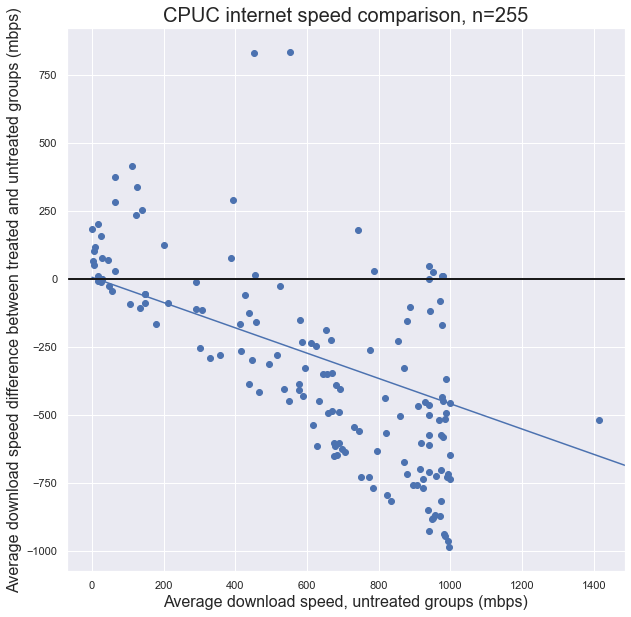

[-0.43943633 12.63612368]


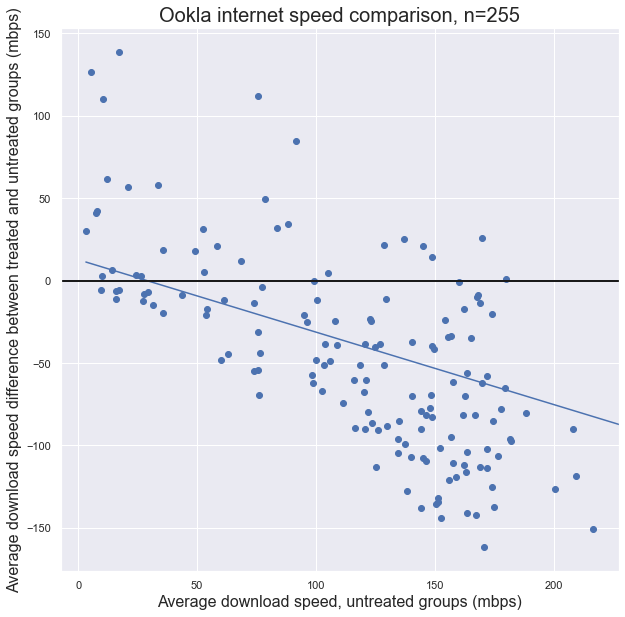

[-0.25440034  0.20383365]


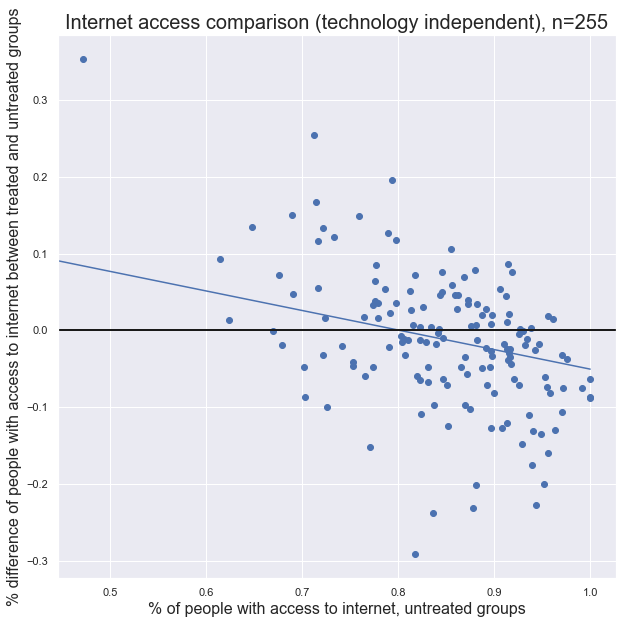

[-0.61076411  0.54940406]


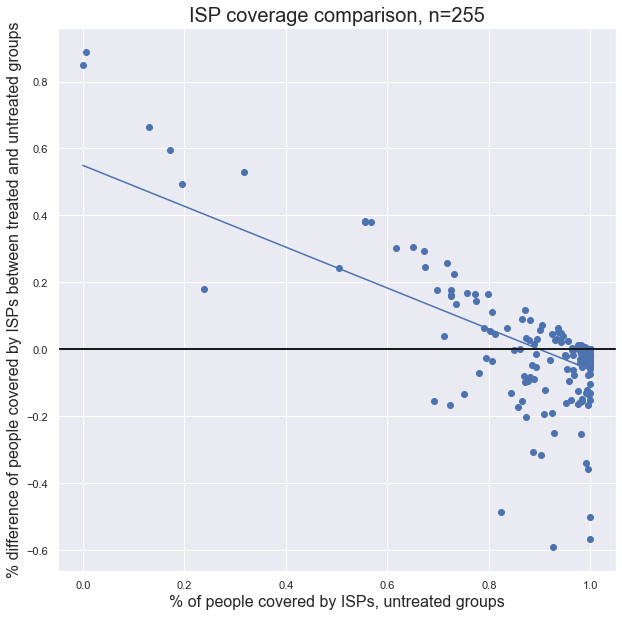

[nan nan]


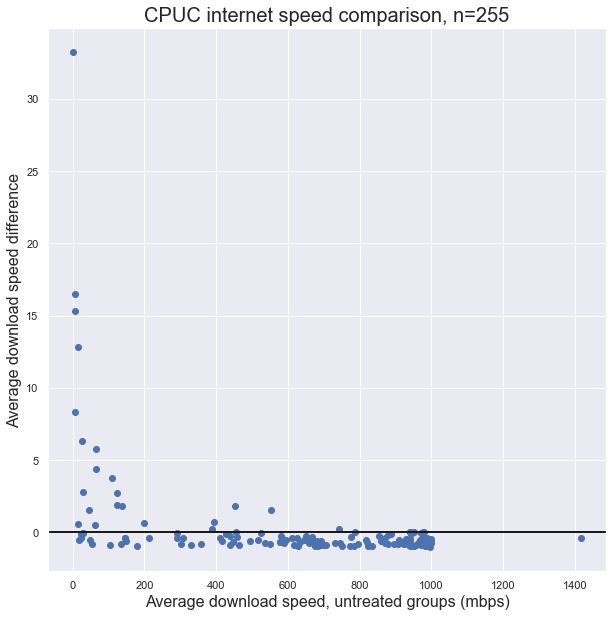

[-1.35216328e-05  1.71189902e-03]


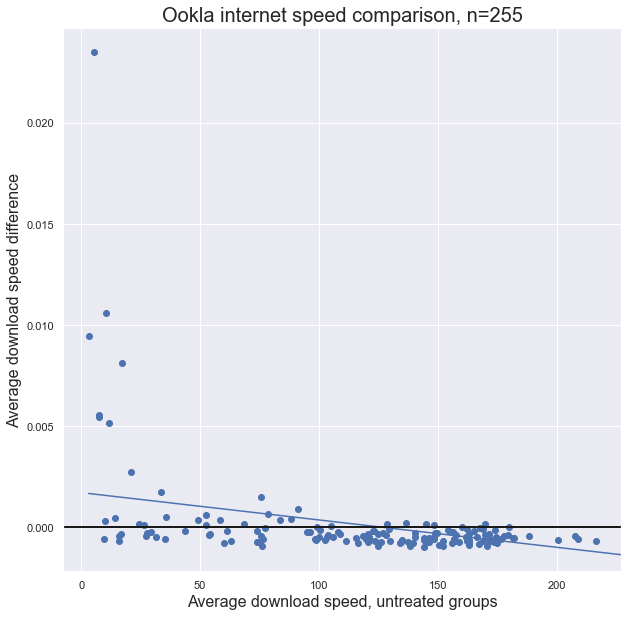

[-0.36133481  0.29669274]


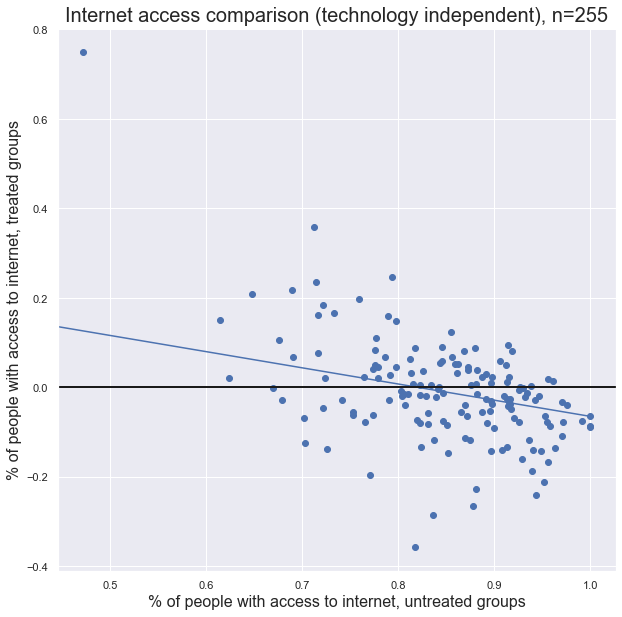

[nan nan]


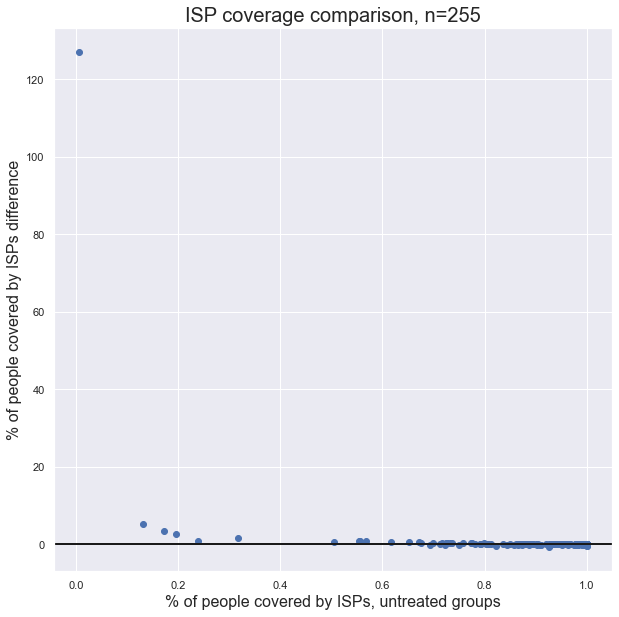

In [197]:
def scatter(x, y, title, xlabel, ylabel, xrange, yrange, line, regression):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    ax.scatter(x, y)
    
    ax.set_title(title+', n='+str(len(x)), fontsize=20)
    
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    
    if xrange != 0:
        ax.set_xlim(yrange)
    if yrange !=0:
        ax.set_ylim(xrange)
        
    _xlim = ax.get_xlim()
    _ylim = ax.get_ylim()
    
    max_lim = max(_xlim[1], _ylim[1])
    min_lim = min(_xlim[0], _ylim[0])
    lim = [min_lim, max_lim]

    if line:
        a = np.linspace(lim[0], lim[1],1000)
        ax.plot(a, a, color='k', linewidth=2)

    if regression:
        #temp = sm.add_constant(data[covariates])
        
        coeffs = np.polyfit(x.fillna(x.median()).squeeze(), y.fillna(y.median()).squeeze(), deg=1)
        
        print(coeffs)
        
        x_intercept = float(-coeffs[1]/coeffs[0])
    
        fit = np.poly1d(coeffs)
        
        fit_equation_x = np.linspace(x.min(), x.max(), len(x))
        fit_equation_y = fit(fit_equation_x)

        ax.plot(fit_equation_x, fit_equation_y)
        #plt.axvline(x=x_intercept, ymin=-10000, ymax=1000, color='k', linewidth=2)
        plt.axhline(y=0, xmin=-1000, xmax=1000, color='k', linewidth=2)

    ax.set_xlim(_xlim)
    ax.set_ylim(_ylim)

    plt.show()

scatter(results[['avg_max_dn_untreated']], results[['avg_max_dn_diff']], 'CPUC internet speed comparison',
        'Average download speed, untreated groups (mbps)', 'Average download speed difference between treated and untreated groups (mbps)', 0,0, False, True)

scatter(results[['avg_d_kbps_wt_untreated']]/1000, results[['avg_d_kbps_wt_diff']]/1000, 'Ookla internet speed comparison',
        'Average download speed, untreated groups (mbps)', 'Average download speed difference between treated and untreated groups (mbps)', 0,0, False, True)

scatter(results[['has_internet_untreated']], results[['has_internet_diff']], 'Internet access comparison (technology independent)',
        '% of people with access to internet, untreated groups', '% difference of people with access to internet between treated and untreated groups', 0,0, False, True)

scatter(results[['served_untreated']], results[['served_diff']], 'ISP coverage comparison',
        '% of people covered by ISPs, untreated groups', '% difference of people covered by ISPs between treated and untreated groups', 0,0, False, True)

scatter(results[['avg_max_dn_untreated']], results[['avg_max_dn_percent_diff']], 'CPUC internet speed comparison',
        'Average download speed, untreated groups (mbps)', 'Average download speed difference', 0,0, False, True)

scatter(results[['avg_d_kbps_wt_untreated']]/1000, results[['avg_d_kbps_wt_percent_diff']]/1000, 'Ookla internet speed comparison',
        'Average download speed, untreated groups', 'Average download speed difference', 0,0, False, True)

scatter(results[['has_internet_untreated']], results[['has_internet_percent_diff']], 'Internet access comparison (technology independent)',
        '% of people with access to internet, untreated groups', '% of people with access to internet, treated groups', 0,0, False, True)

scatter(results[['served_untreated']], results[['served_percent_diff']], 'ISP coverage comparison',
        '% of people covered by ISPs, untreated groups', '% of people covered by ISPs difference', 0,0, False, True)

# scatter(results[['avg_max_dn_untreated']], results[['avg_max_dn_treated']], 'CPUC internet speed comparison',
#         'Average download speed, untreated groups', 'Average download speed differene', 0,0, True, True)

# scatter(results[['avg_d_kbps_wt_untreated']]/1000, results[['avg_d_kbps_wt_treated']]/1000, 'Ookla internet speed comparison',
#         'Average download speed, untreated groups', 'Average download speed, treated groups', 0,0, True, True)

# scatter(results[['has_internet_untreated']], results[['has_internet_treated']], 'Internet access comparison (technology independent)',
#         '% of people with access to internet, untreated groups', '% of people with access to internet, treated groups', 0,0, True, True)

# scatter(results[['served_untreated']], results[['served_treated']], 'ISP coverage comparison',
#         '% of people covered by ISPs, untreated groups', '% of people covered by ISPs, treated groups', 0,0, True, True)

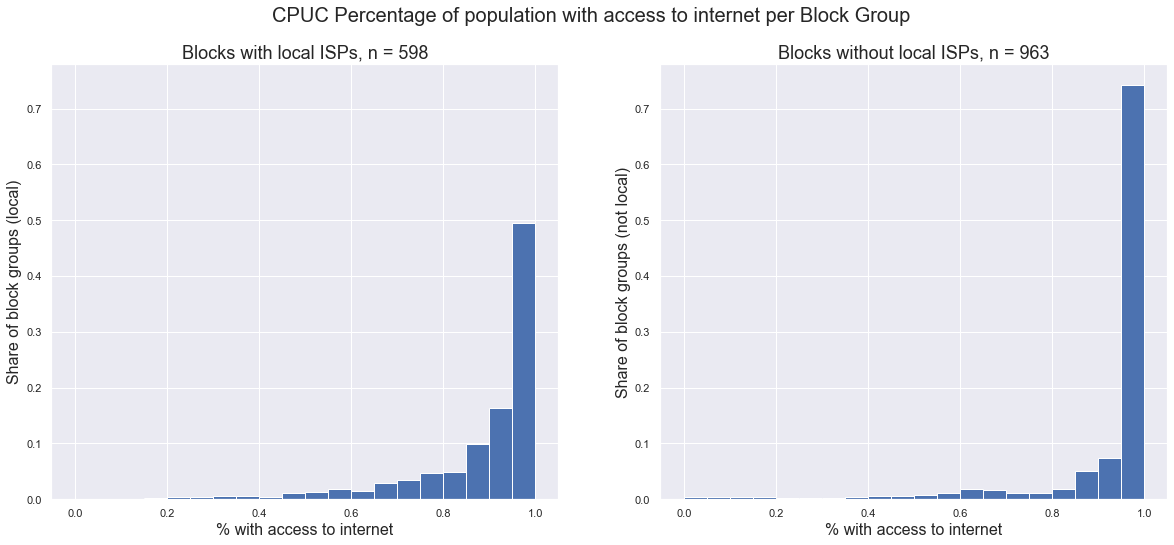

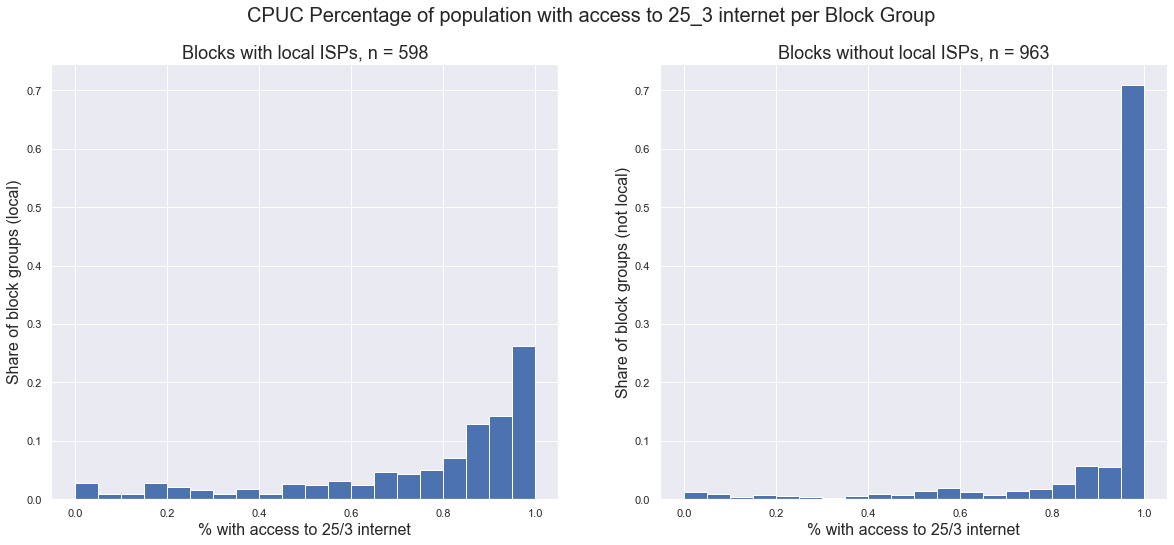

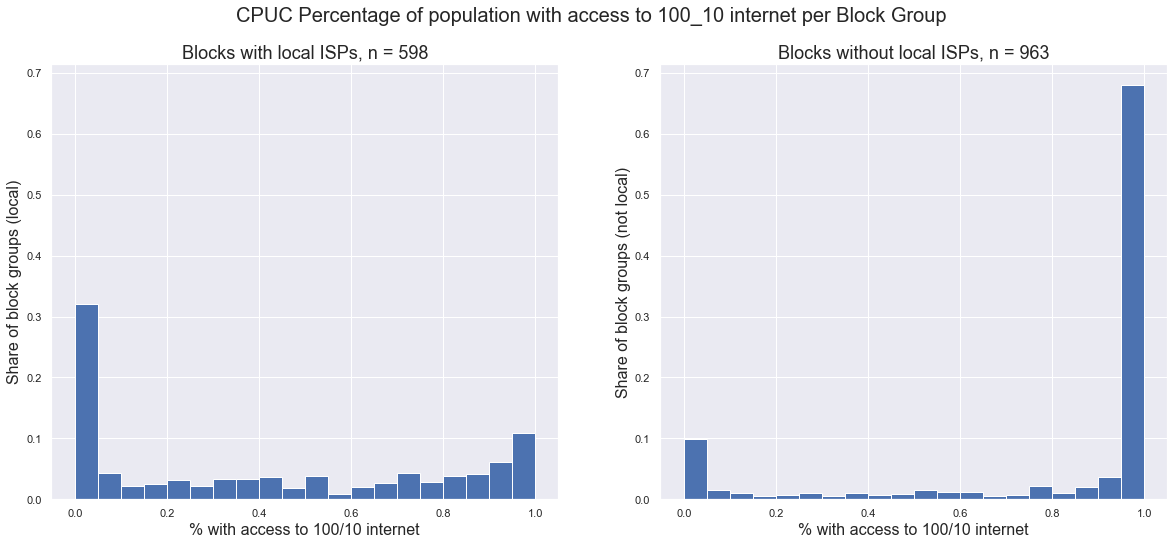

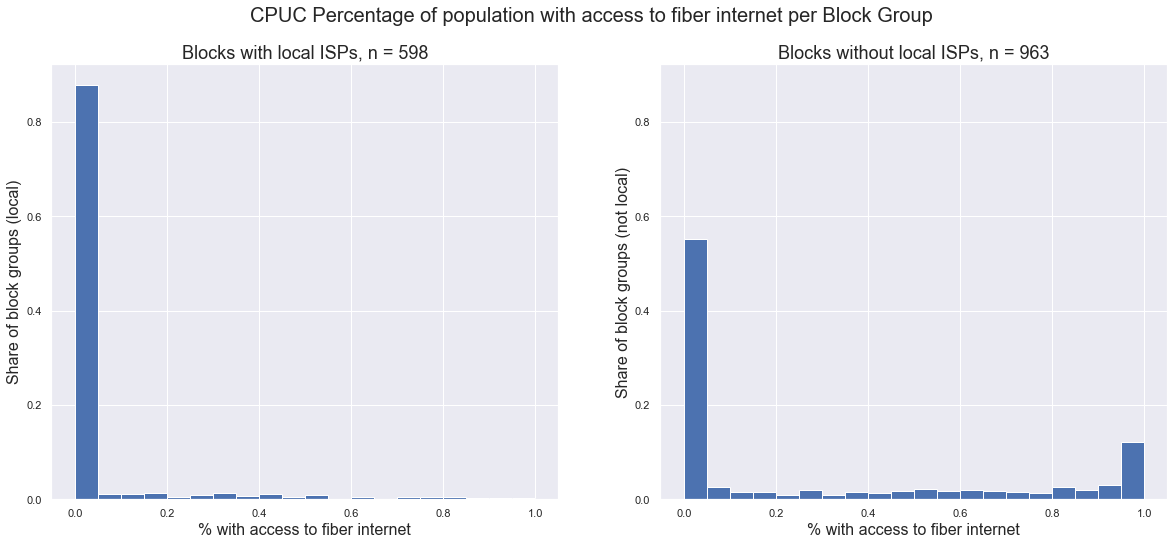

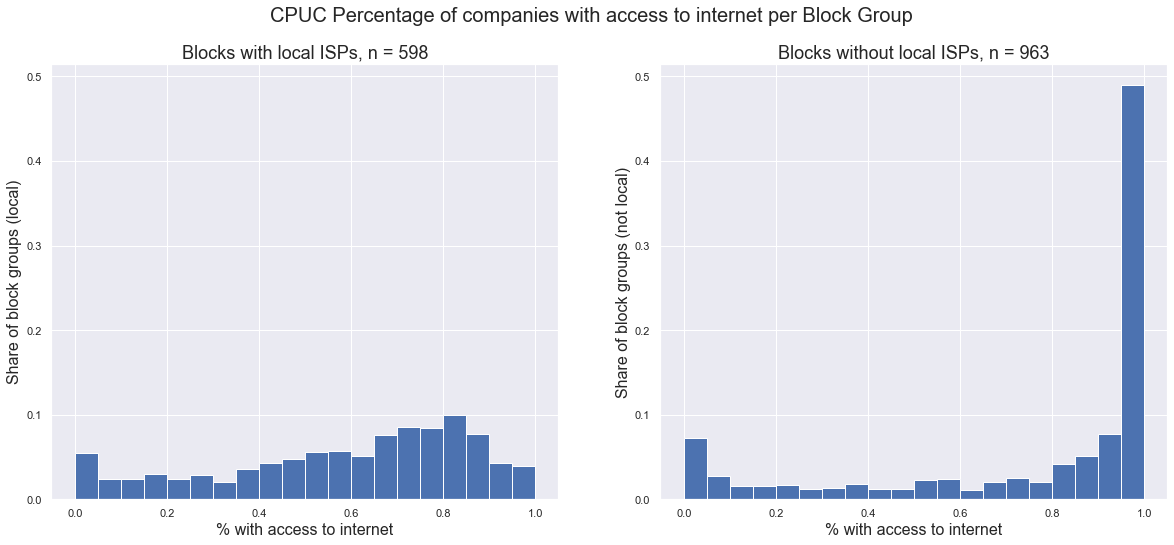

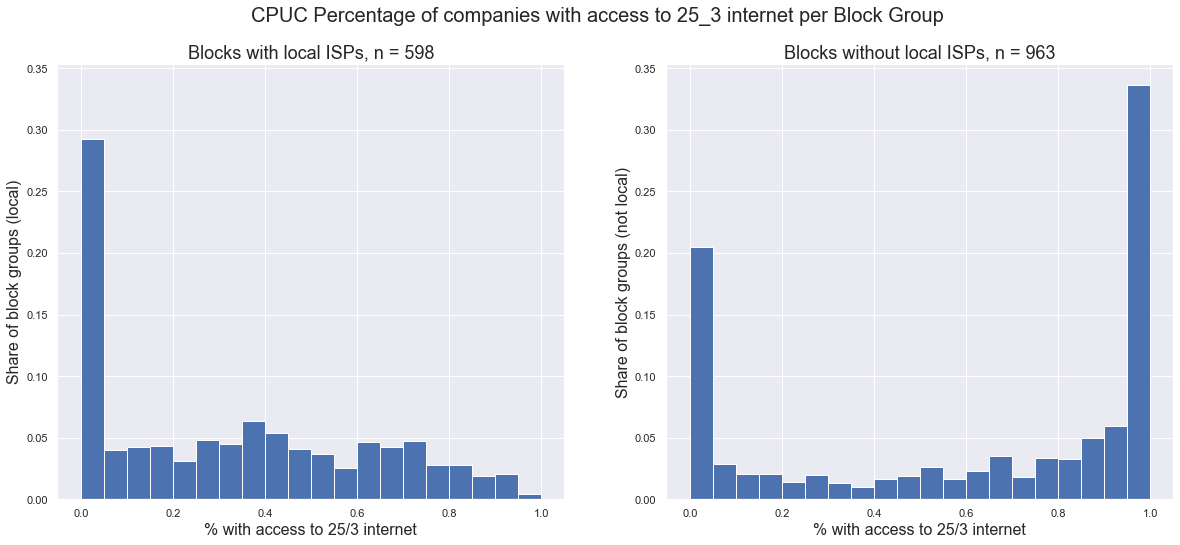

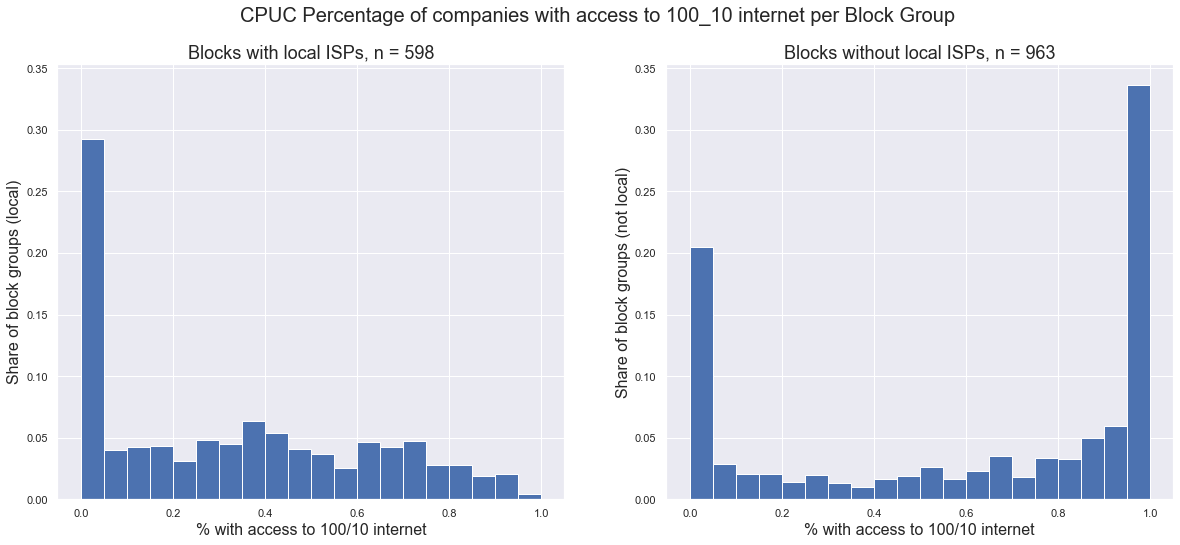

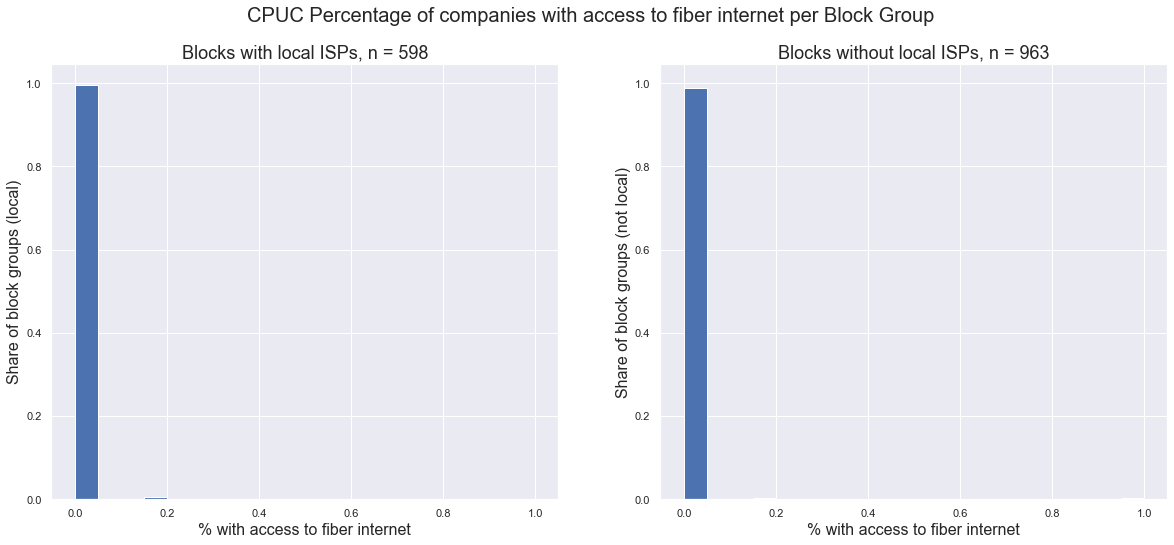

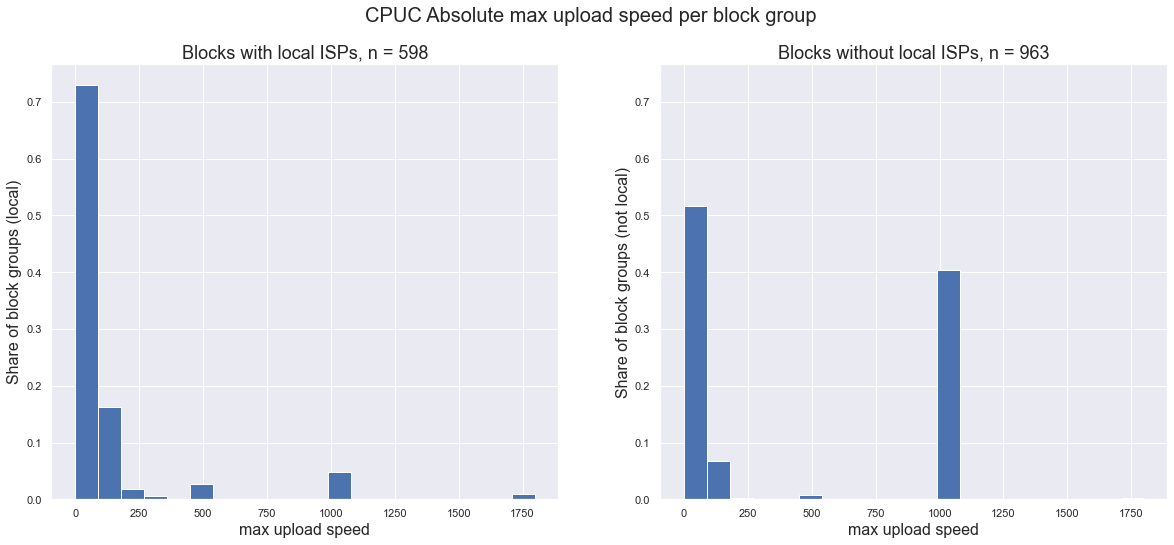

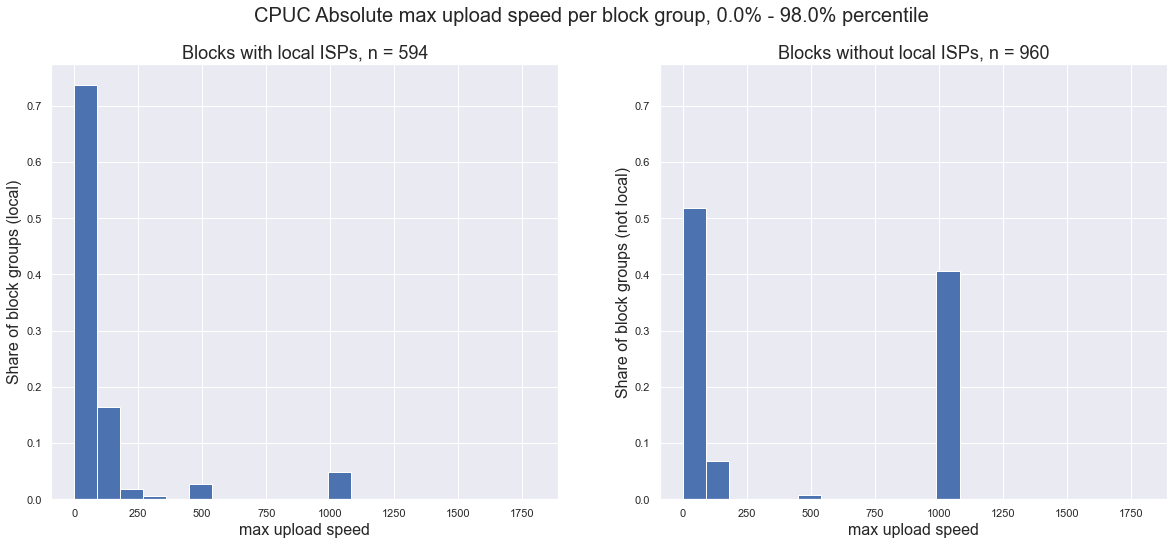

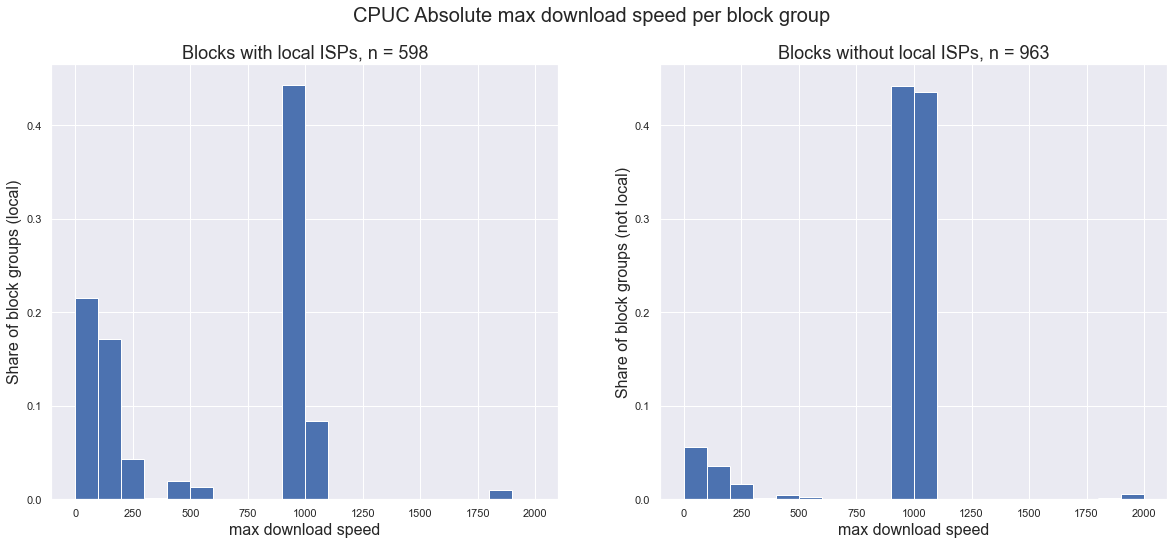

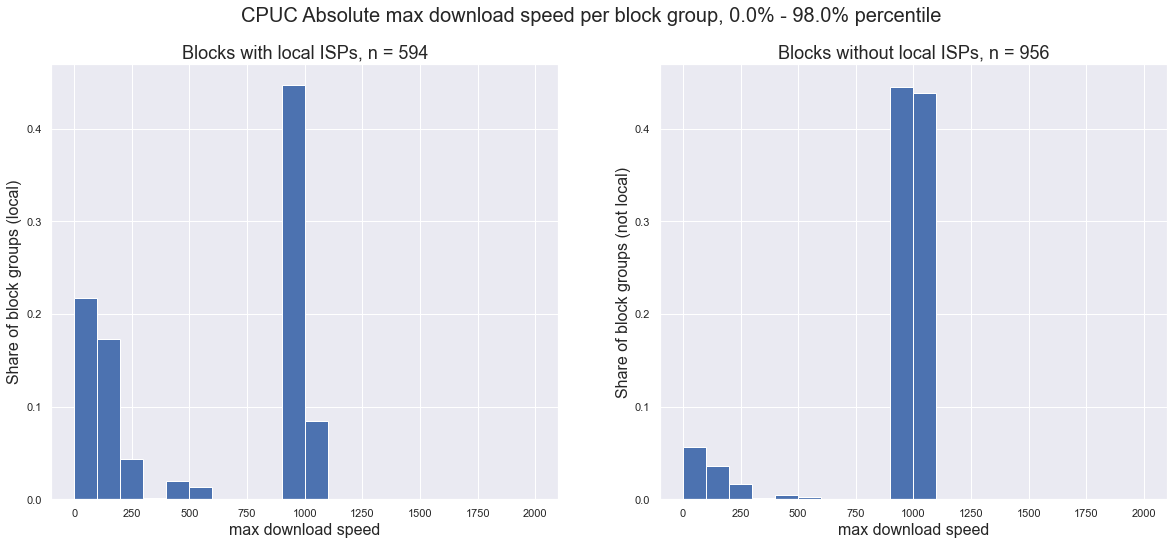

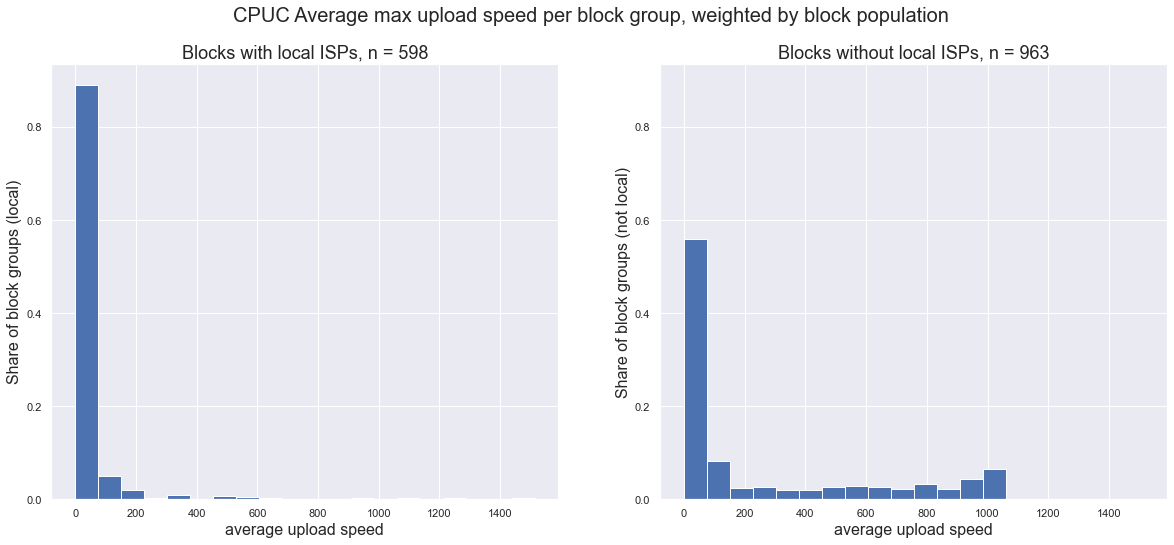

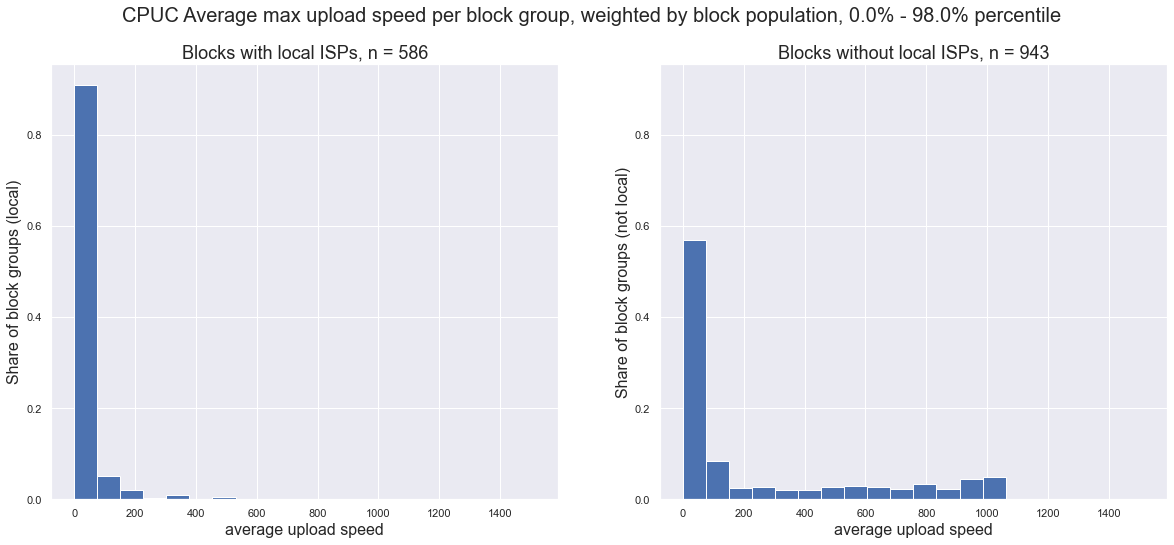

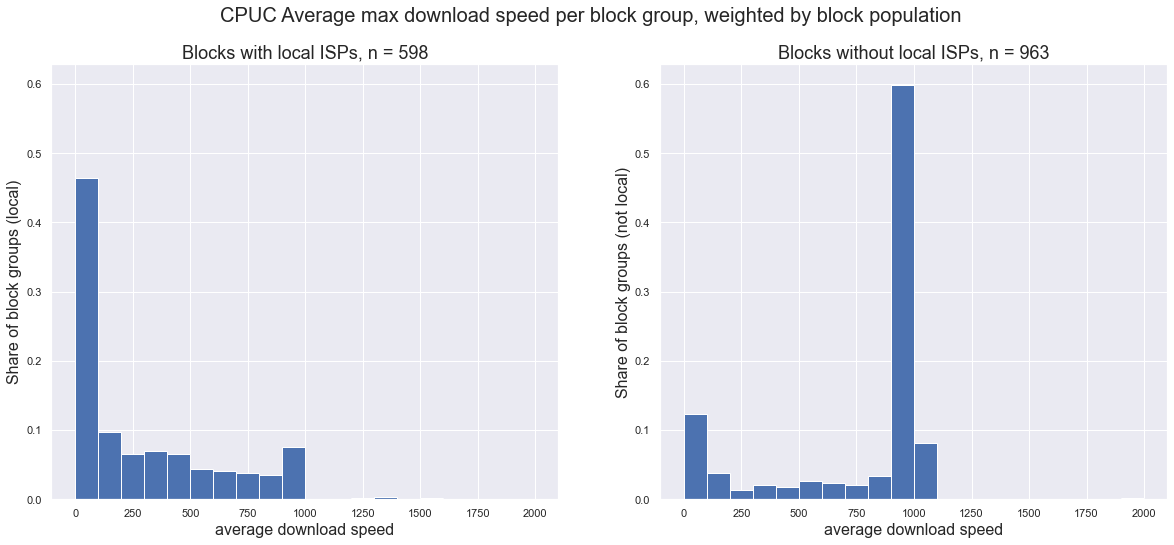

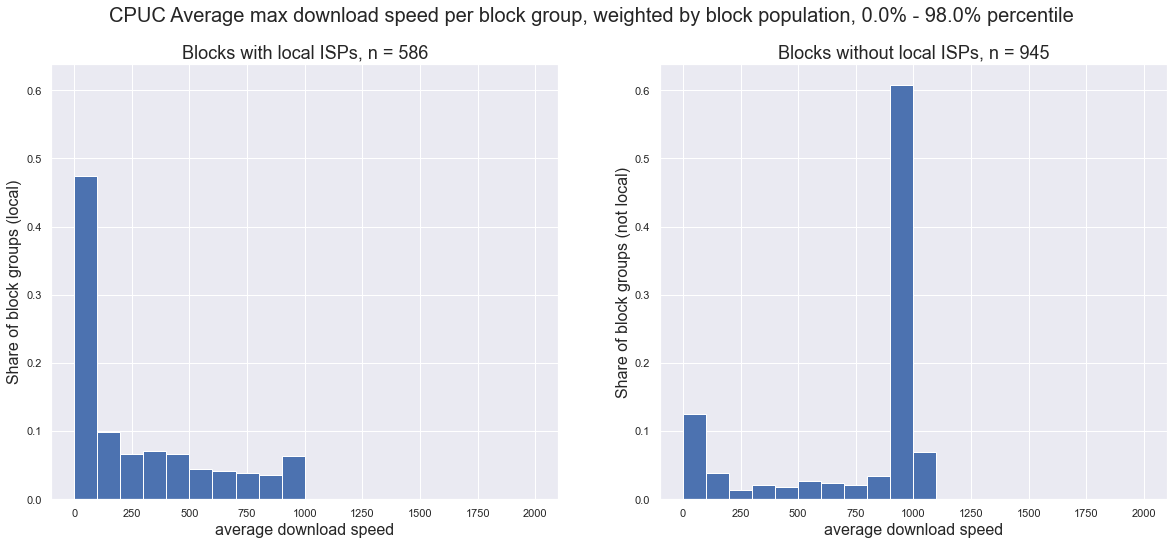

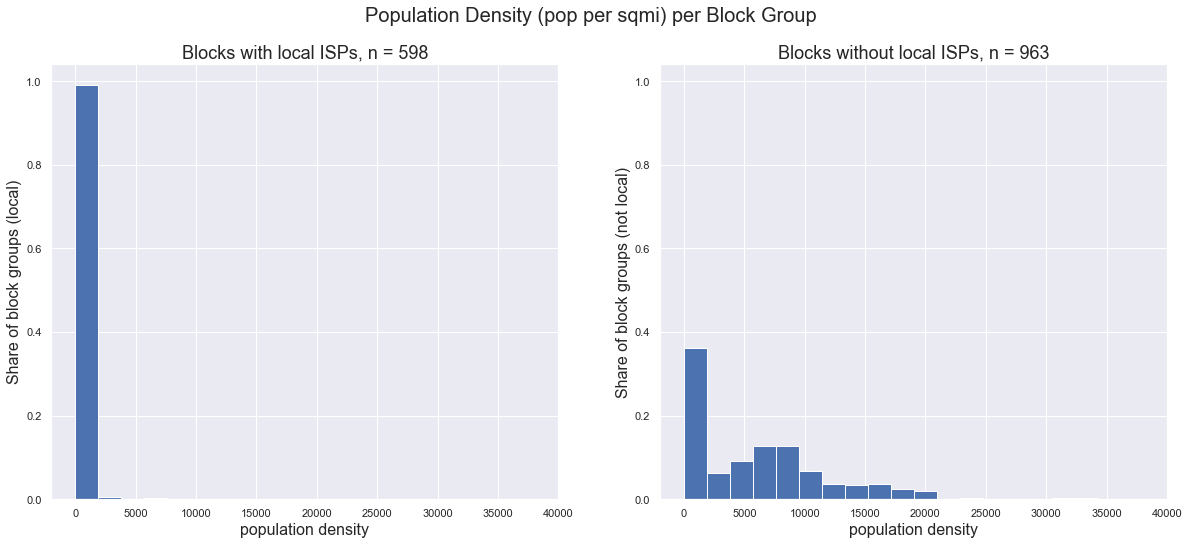

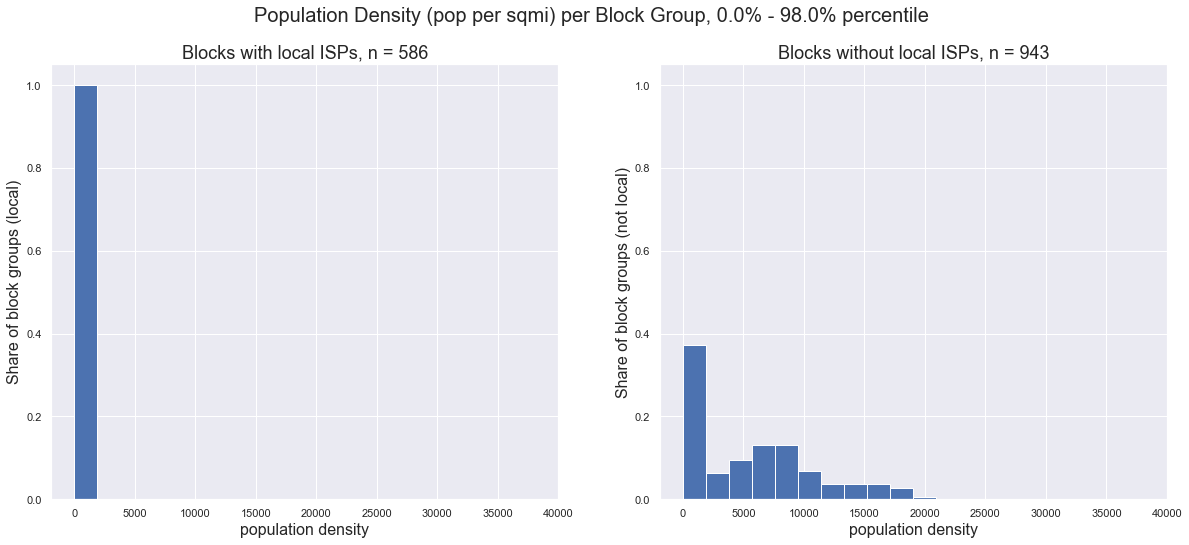

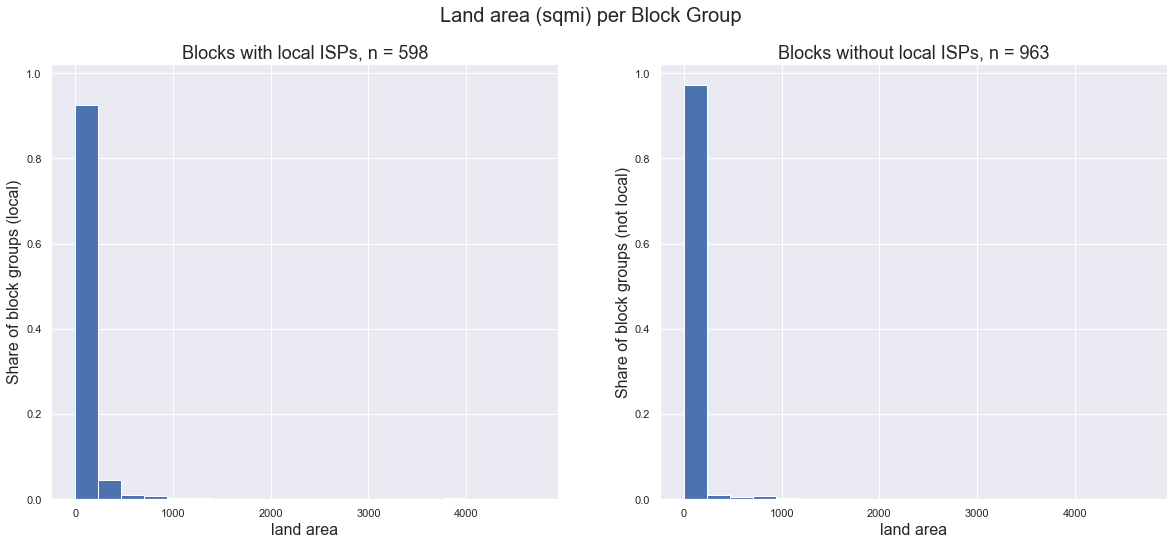

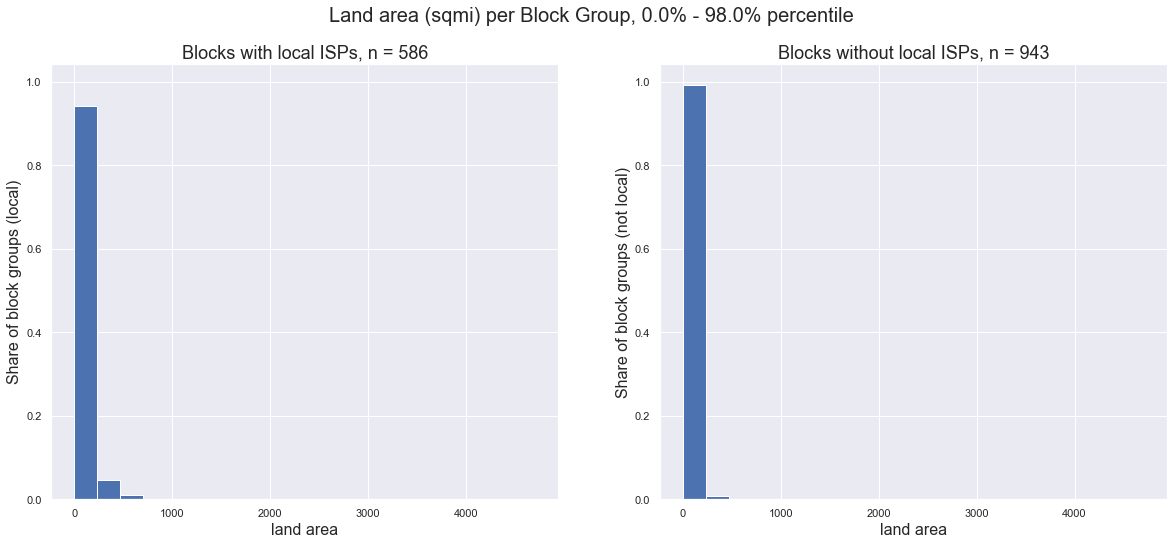

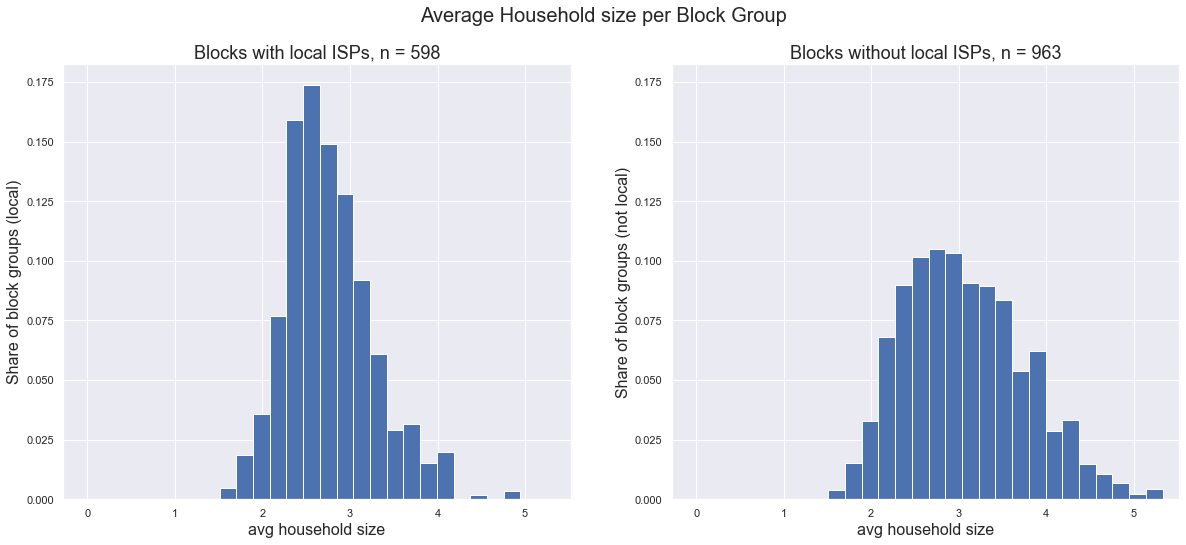

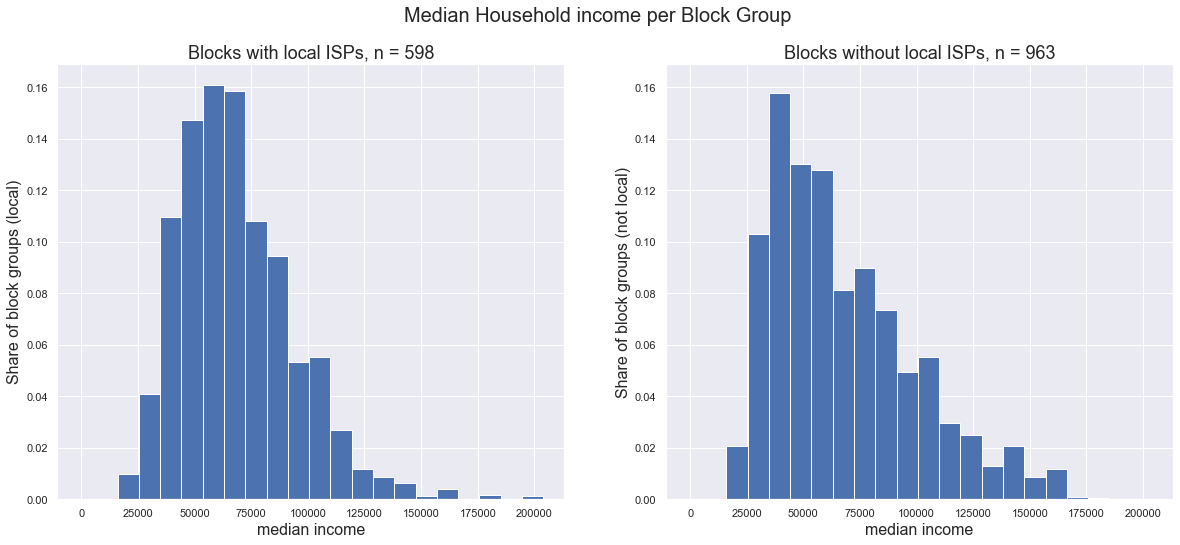

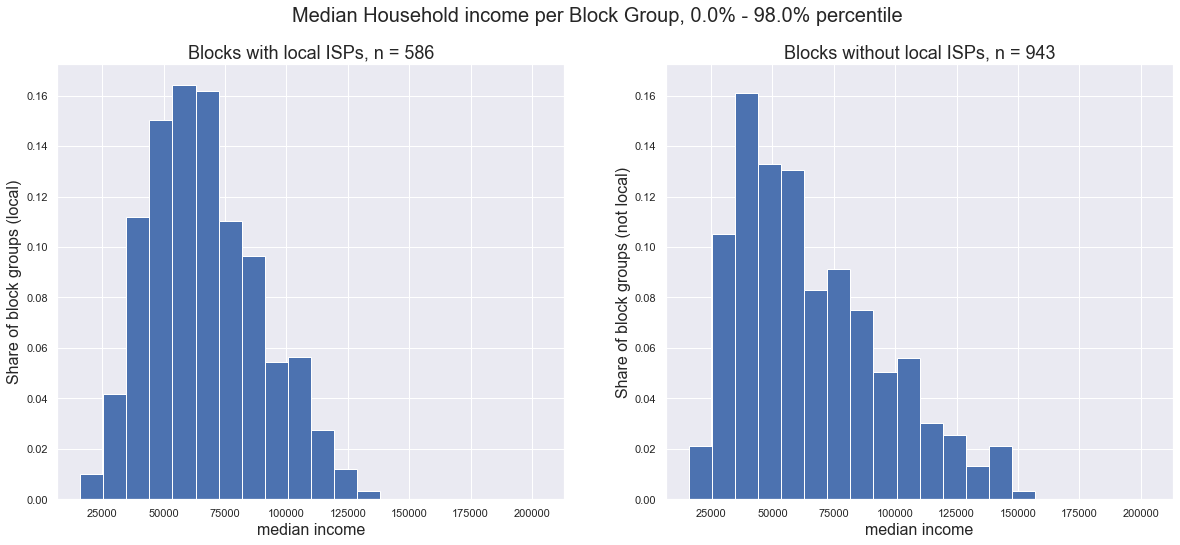

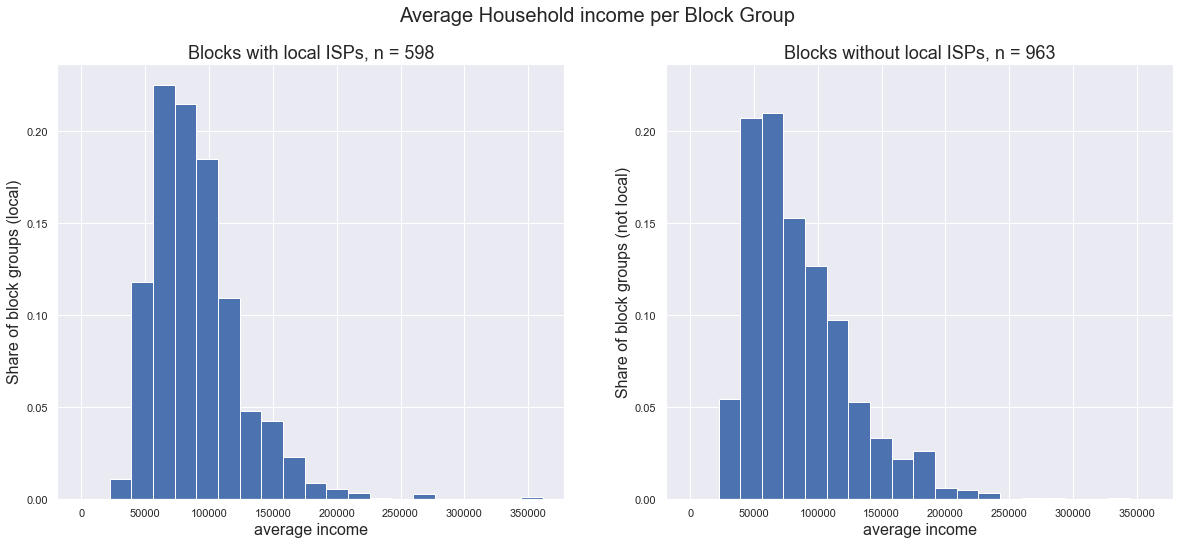

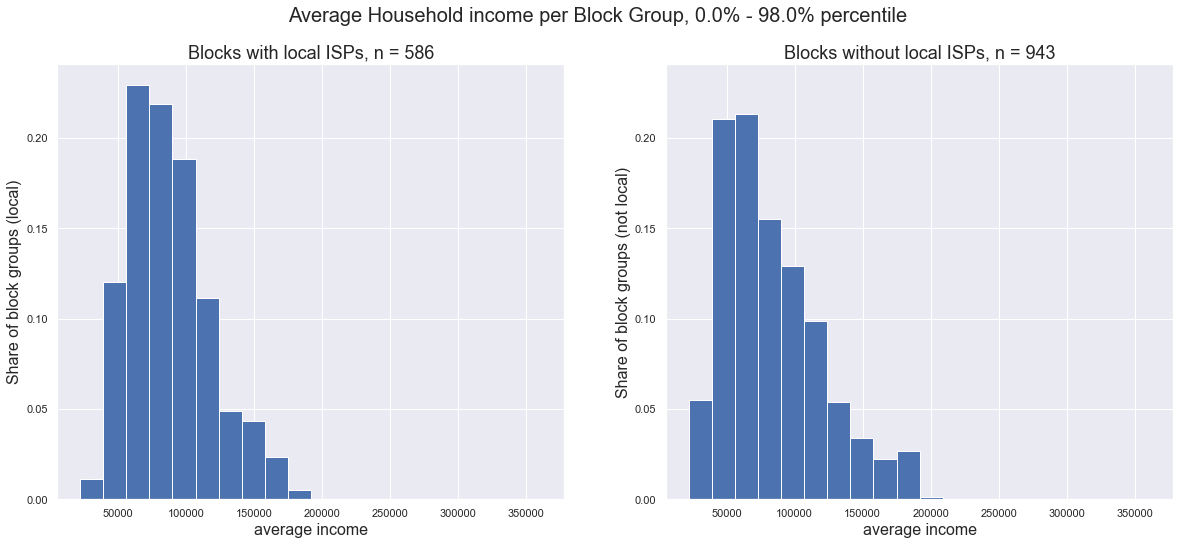

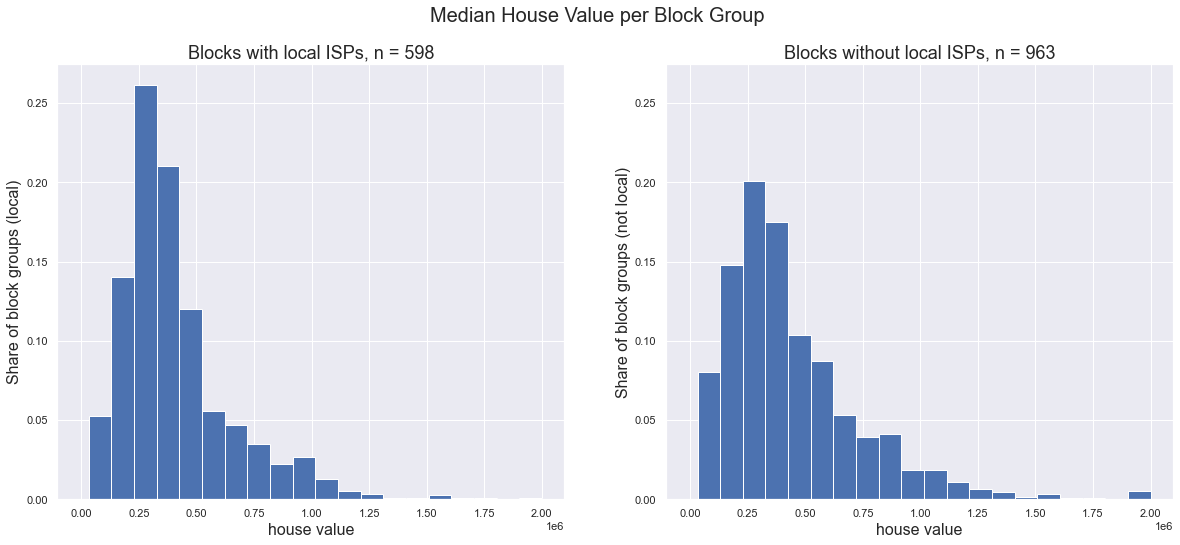

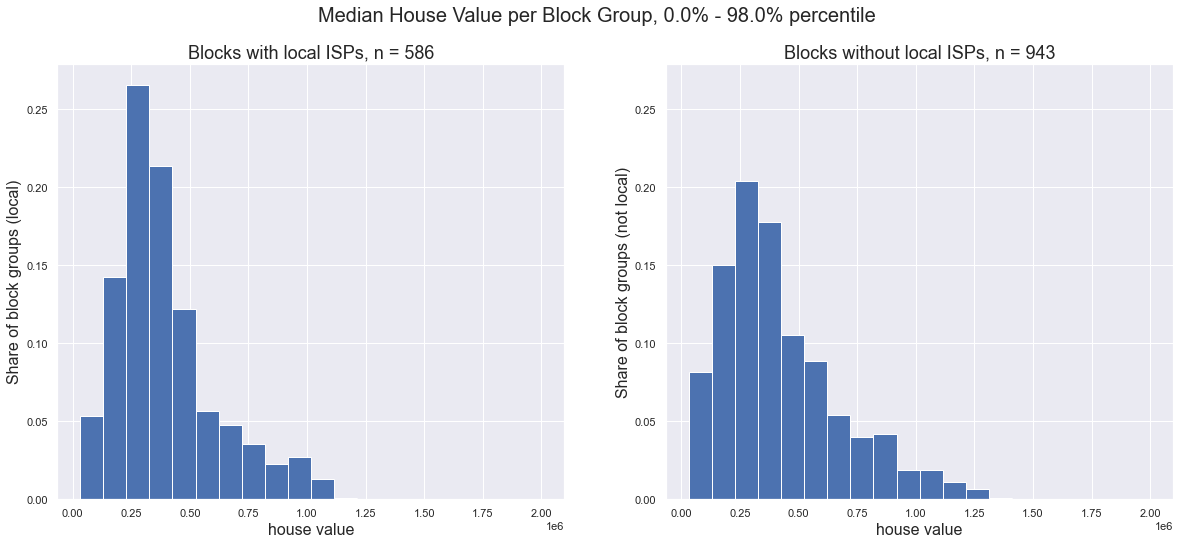

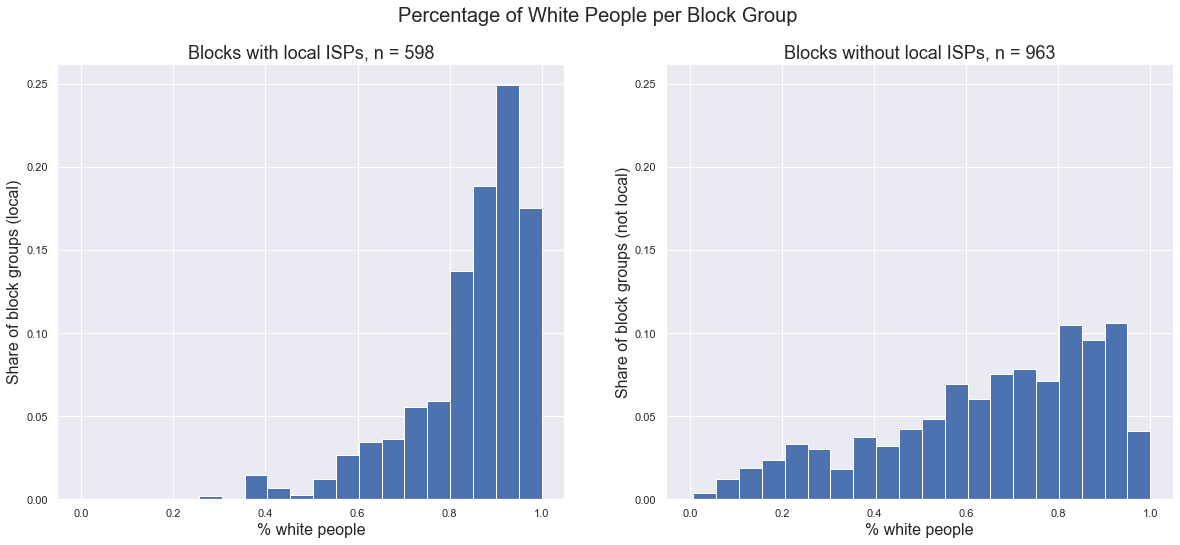

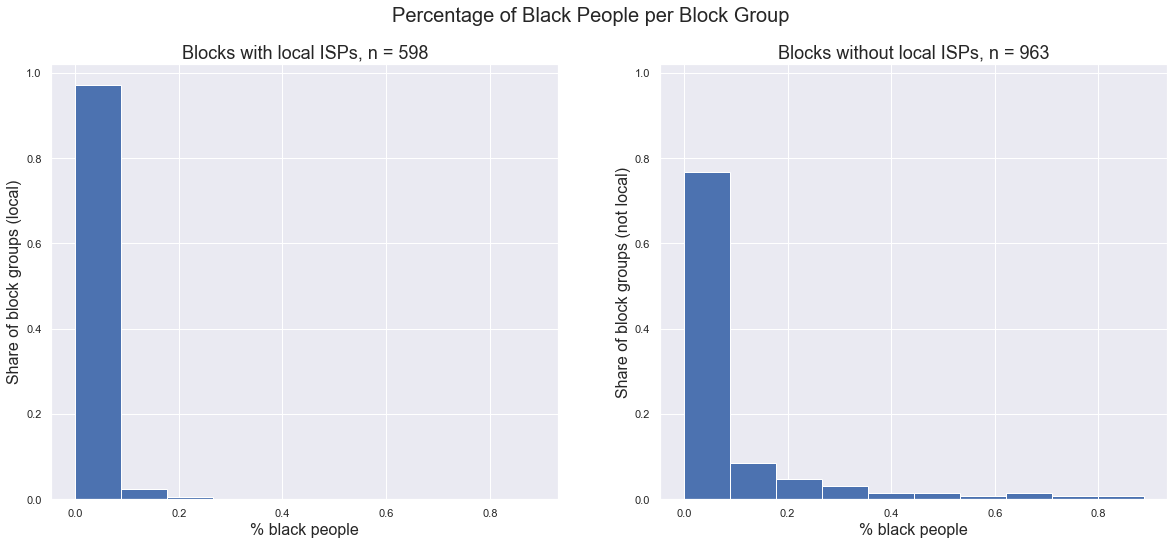

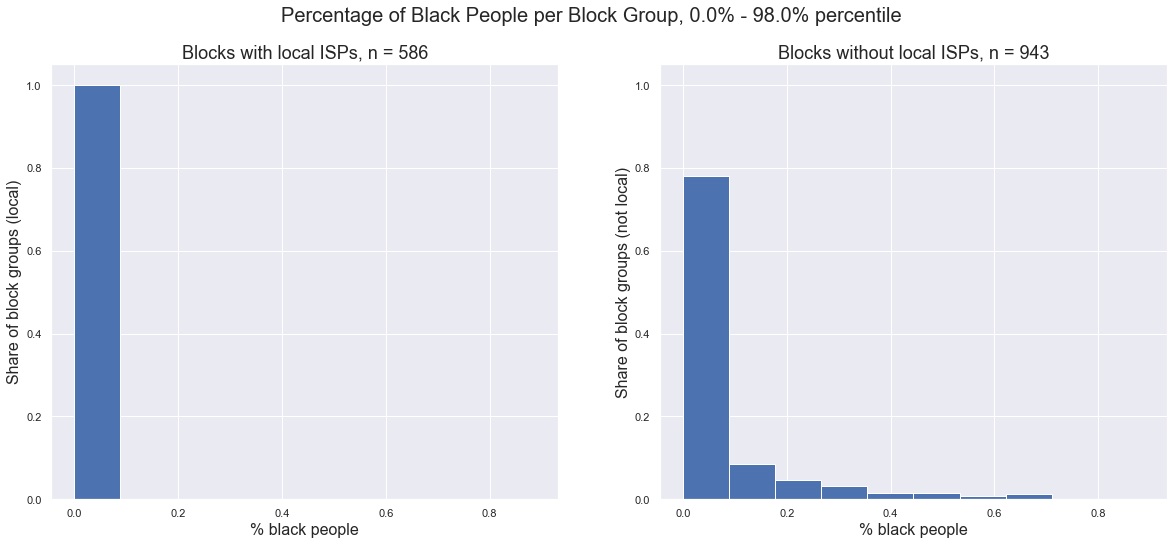

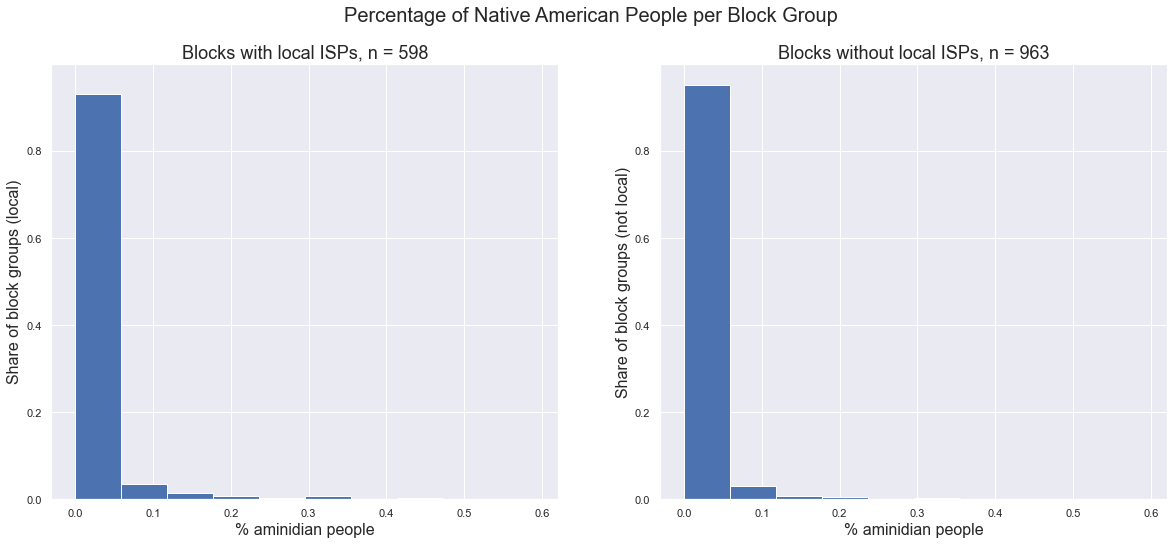

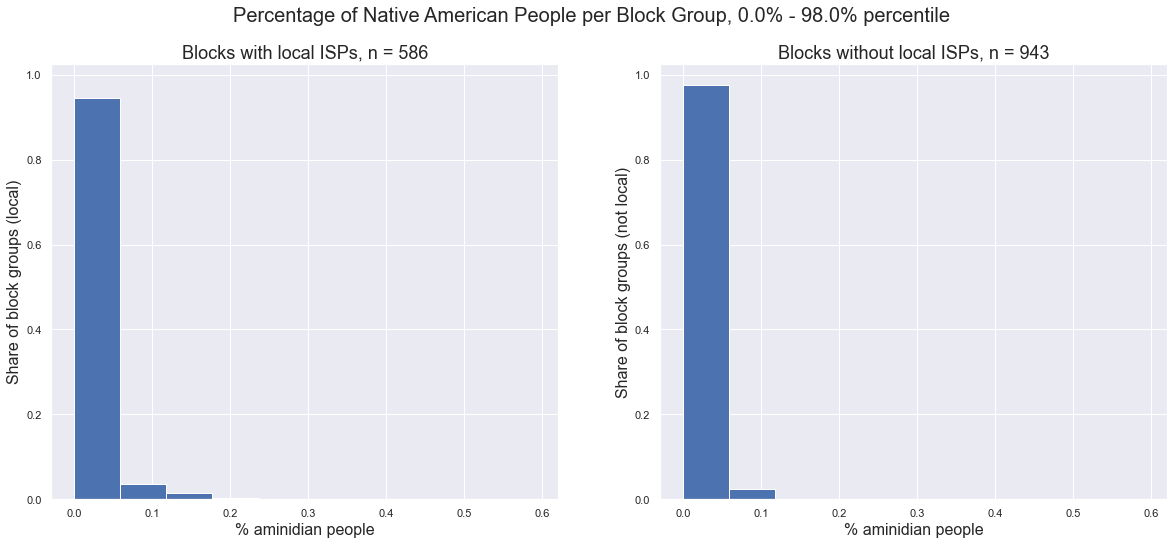

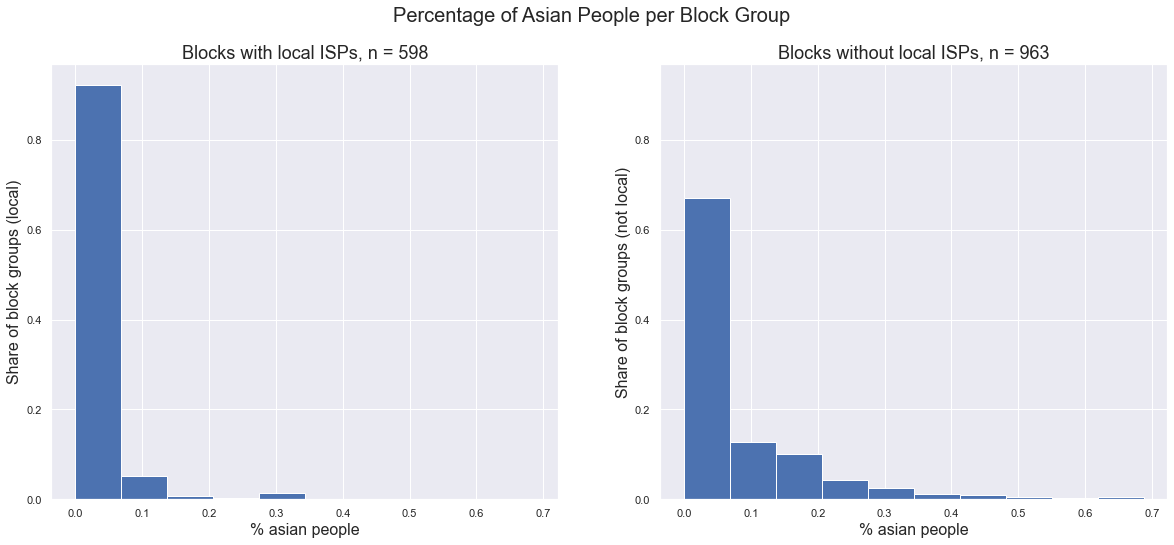

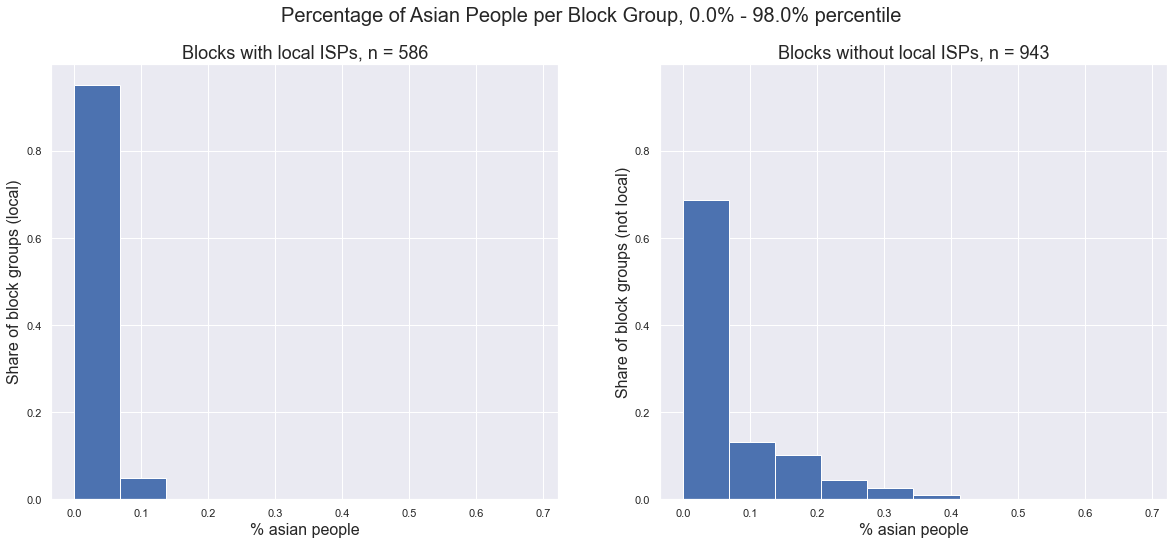

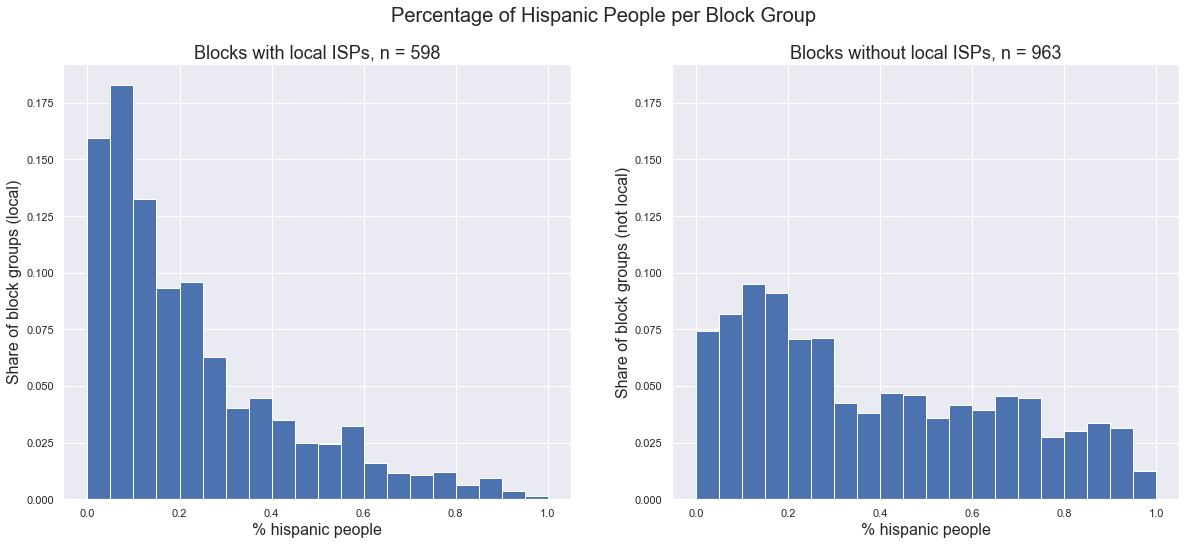

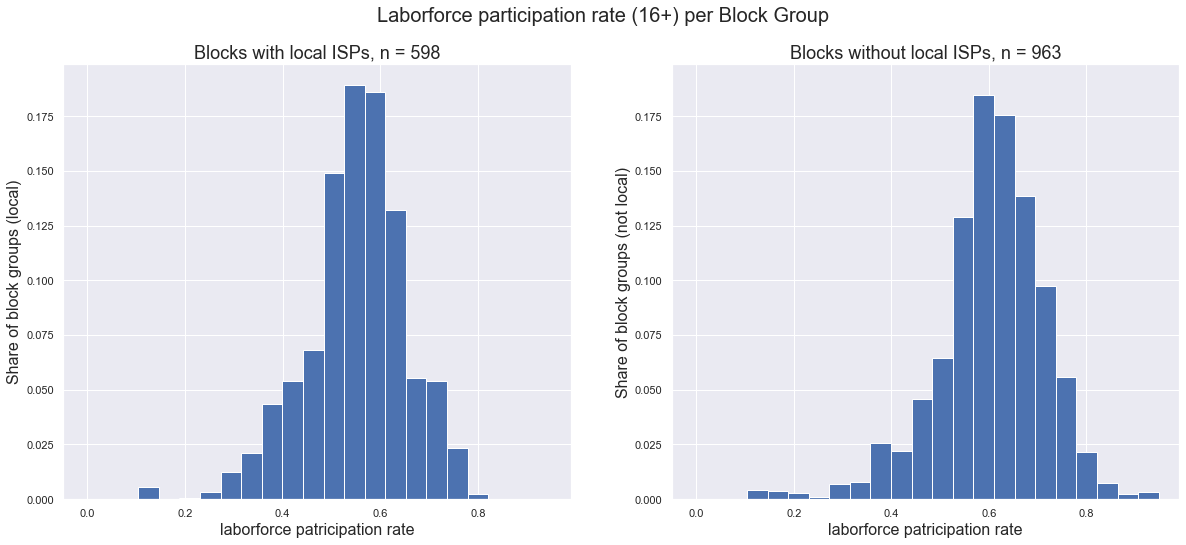

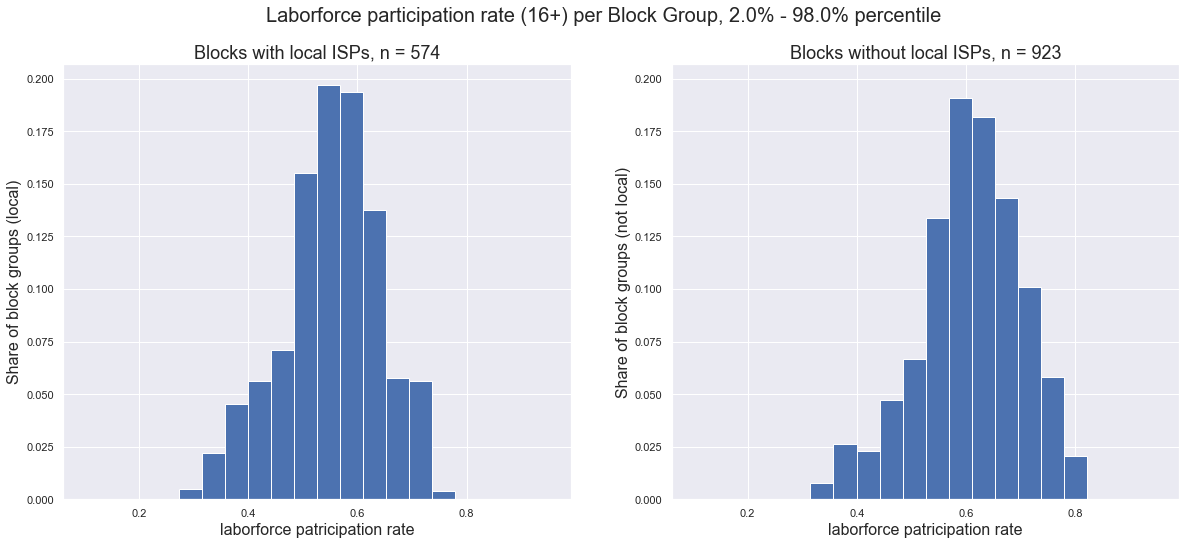

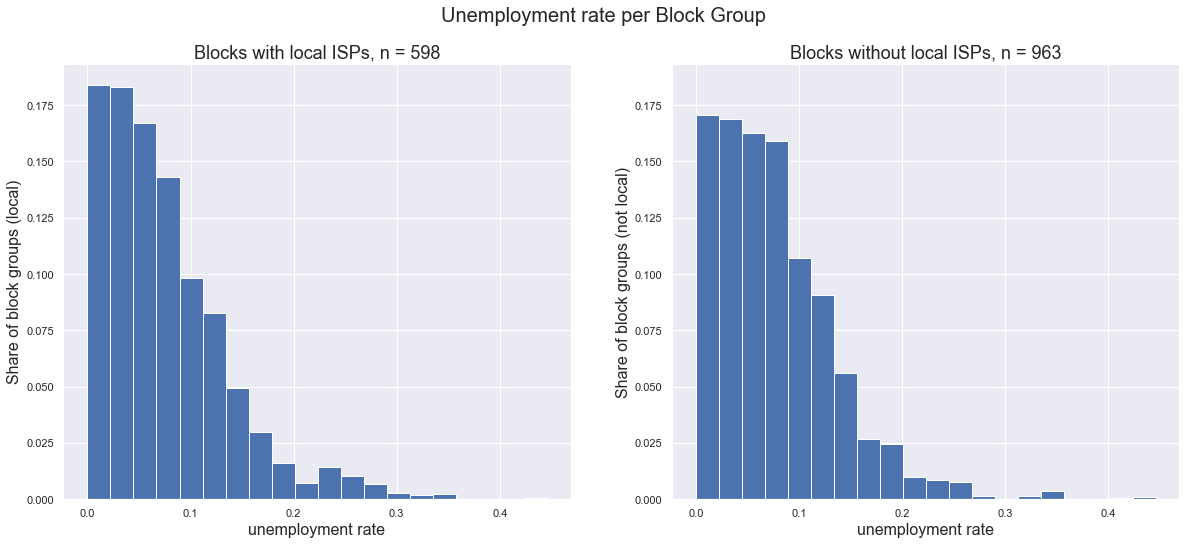

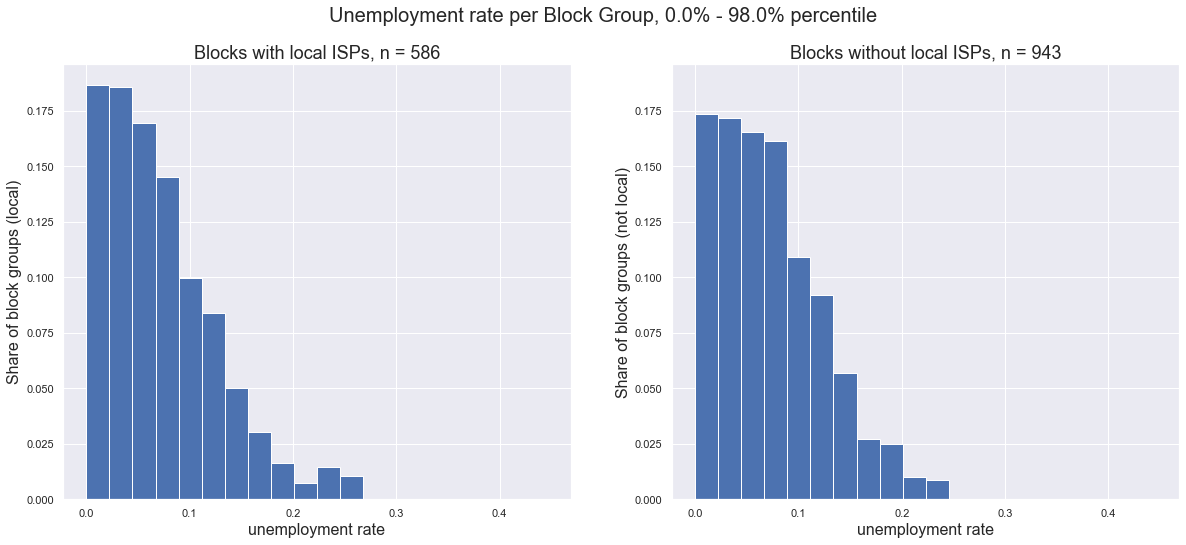

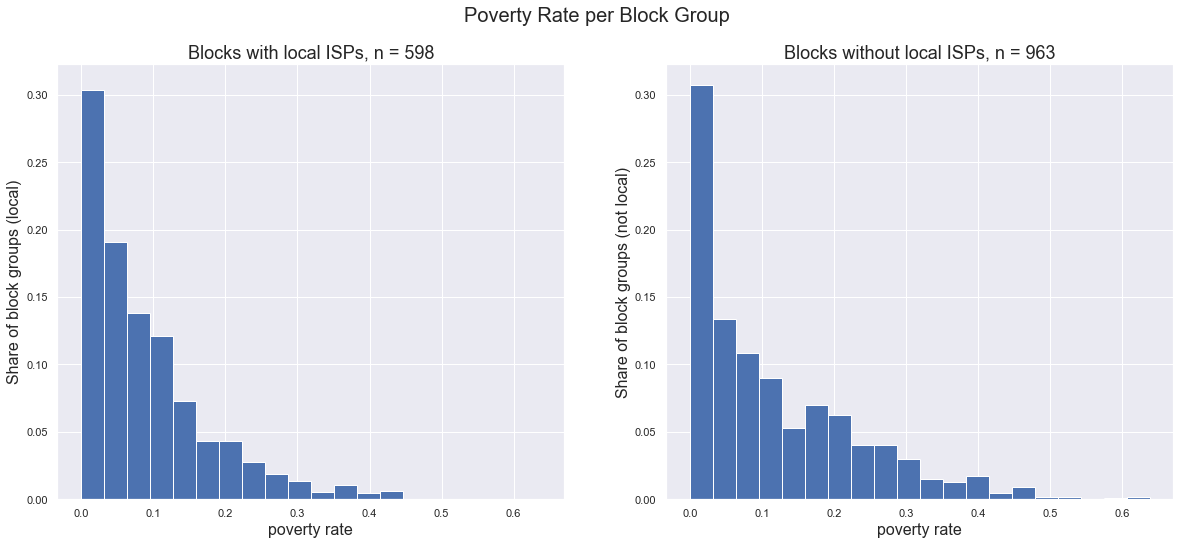

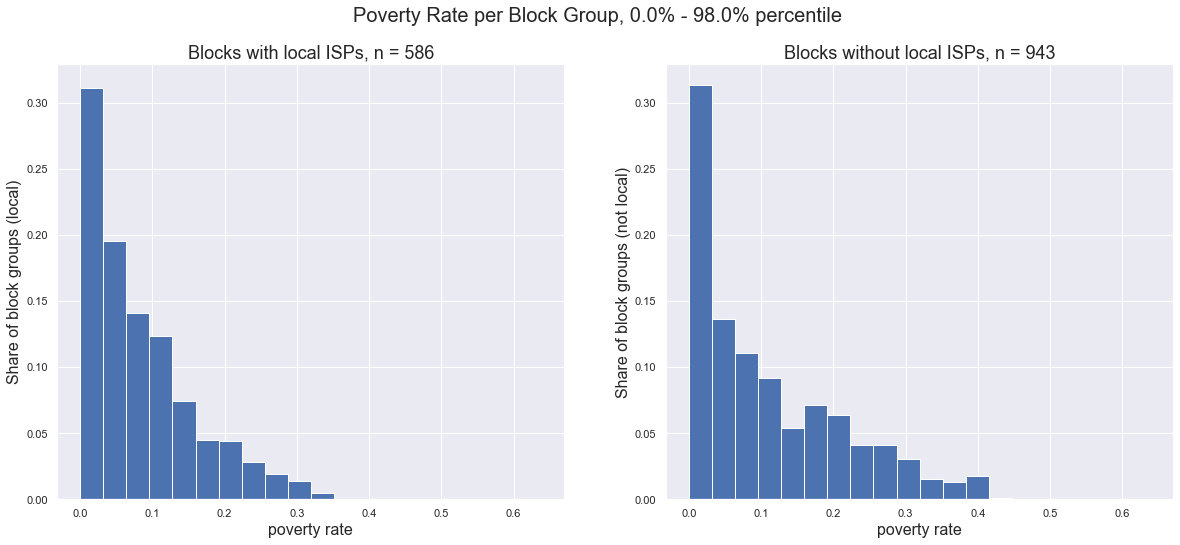

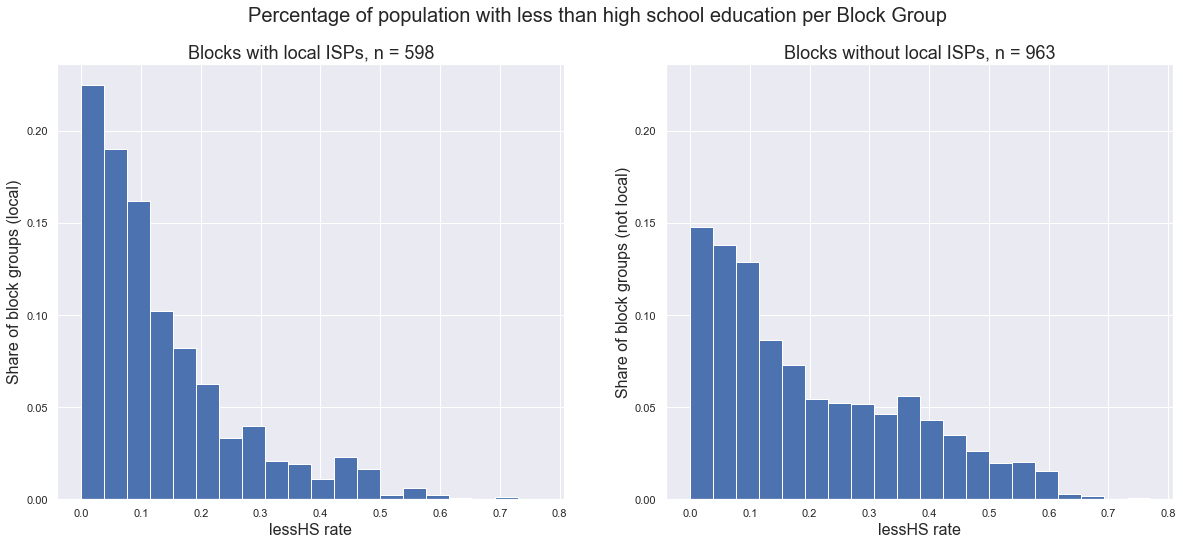

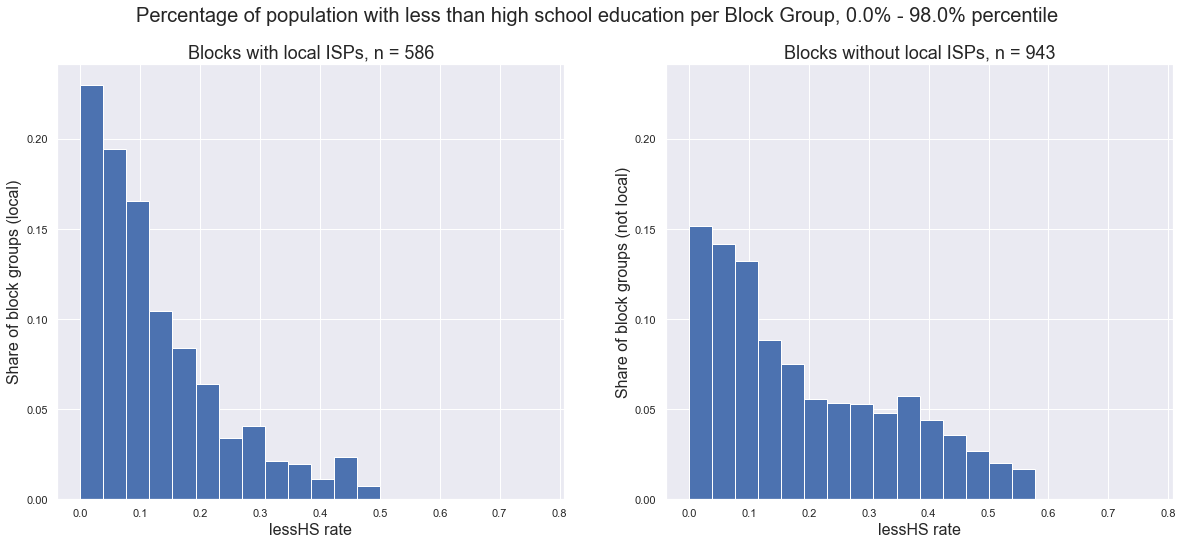

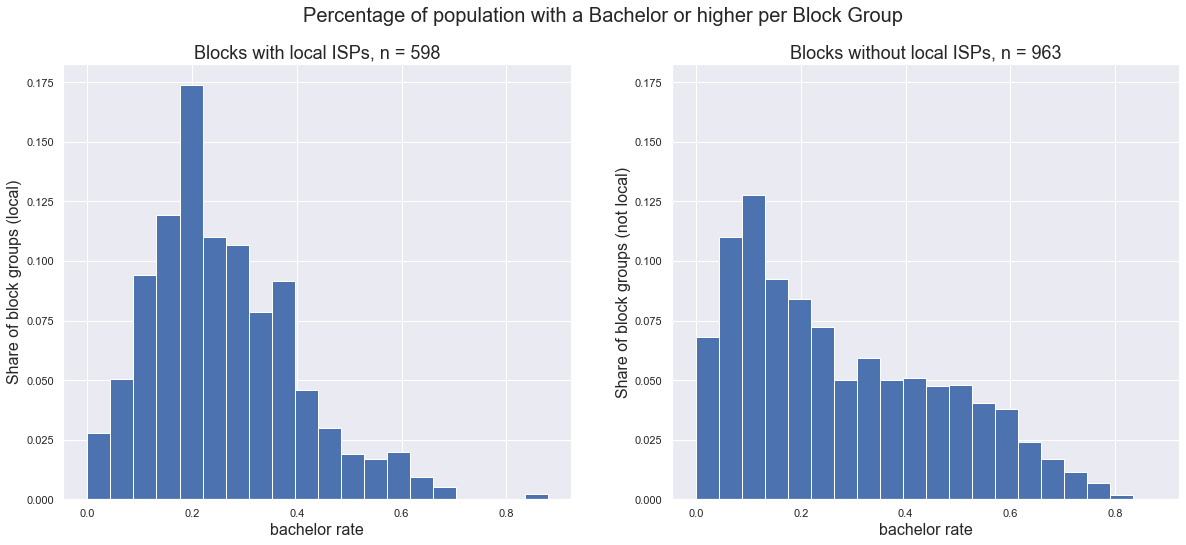

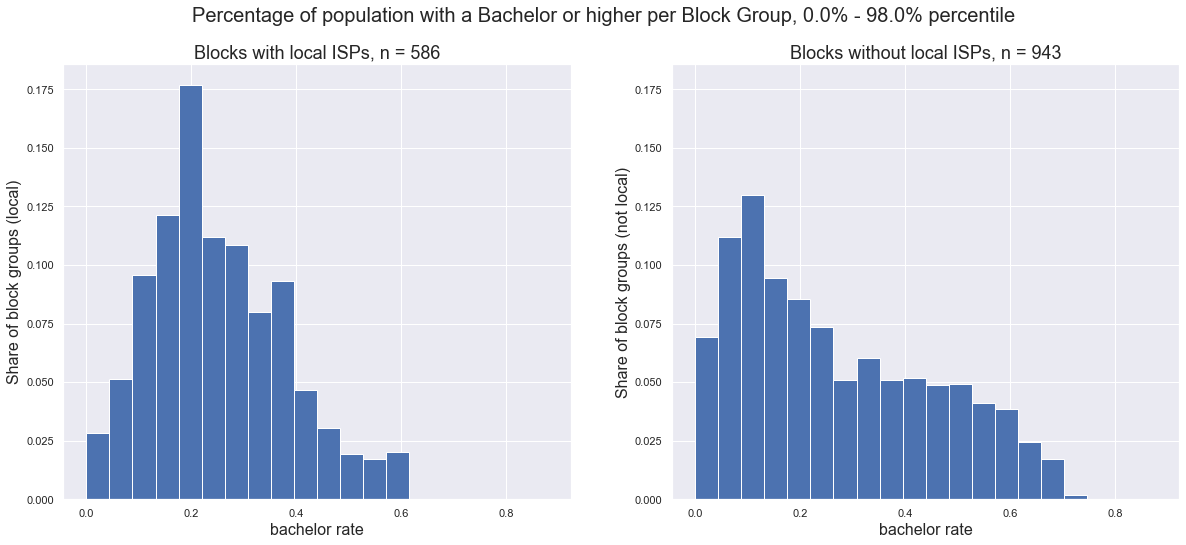

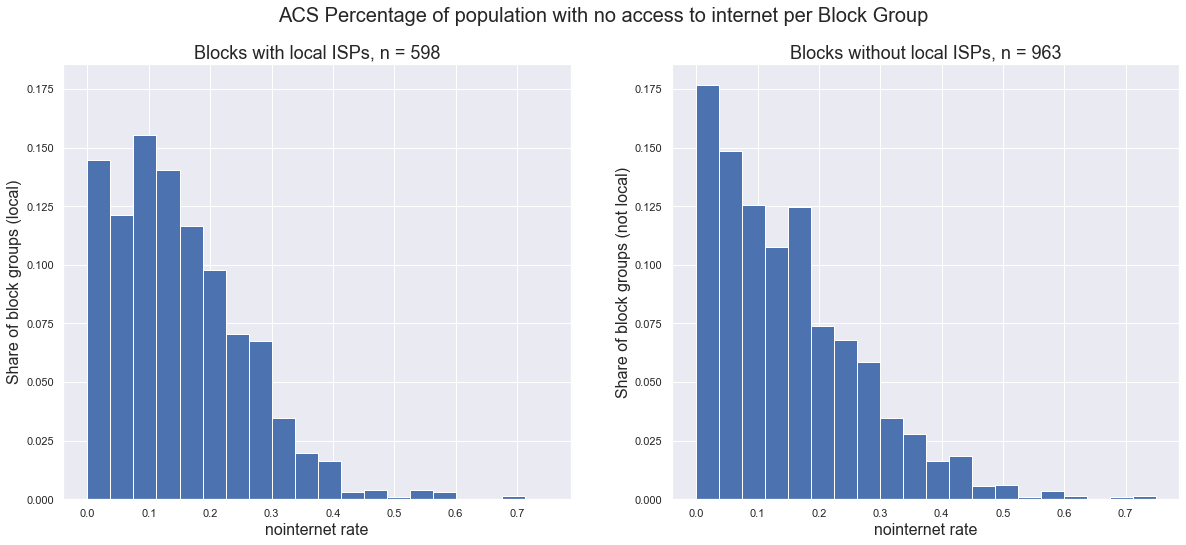

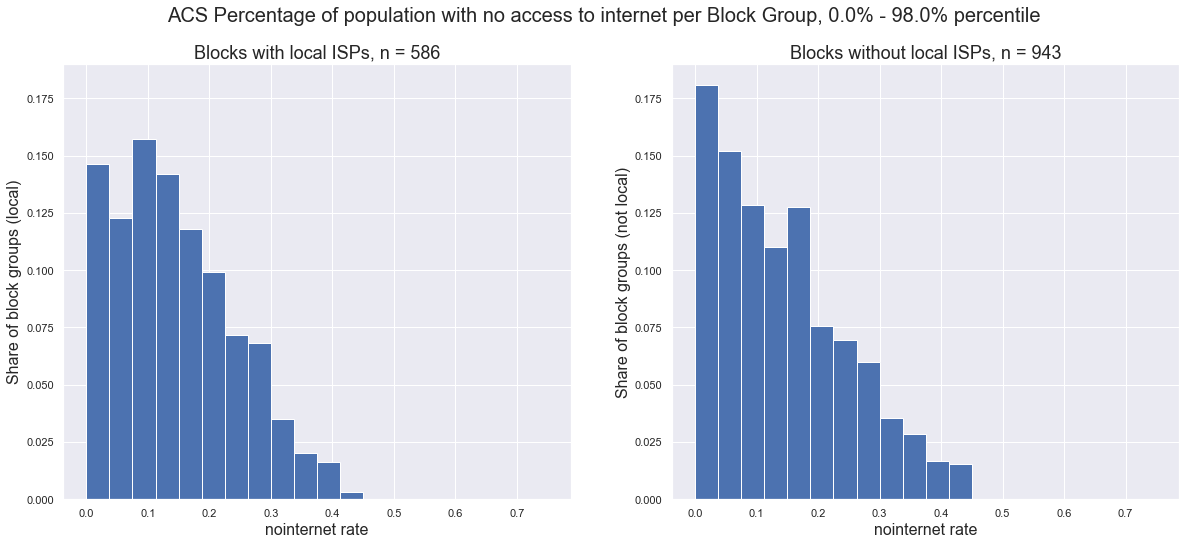

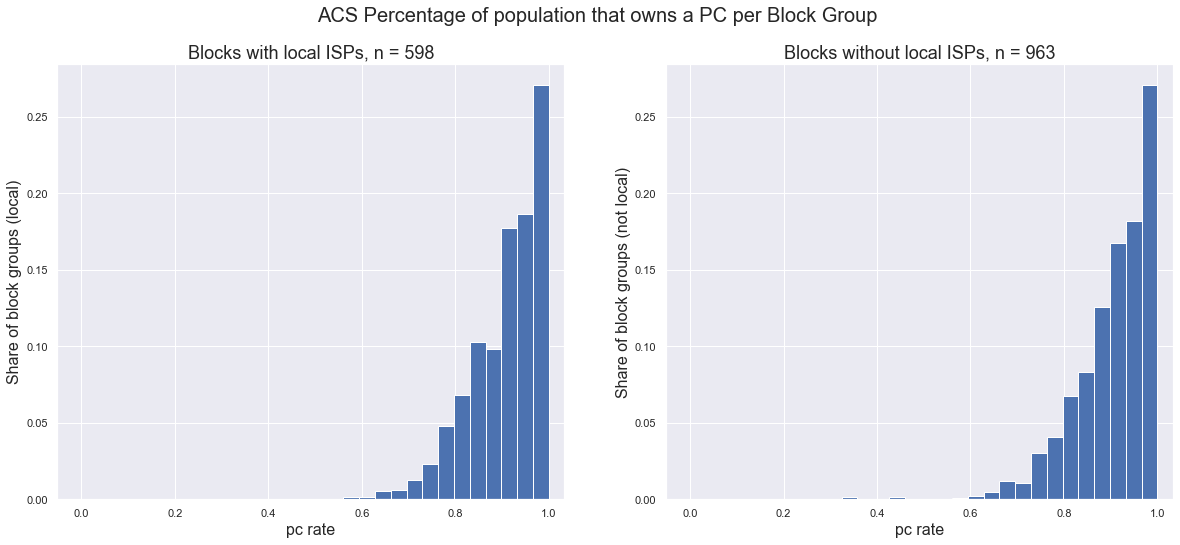

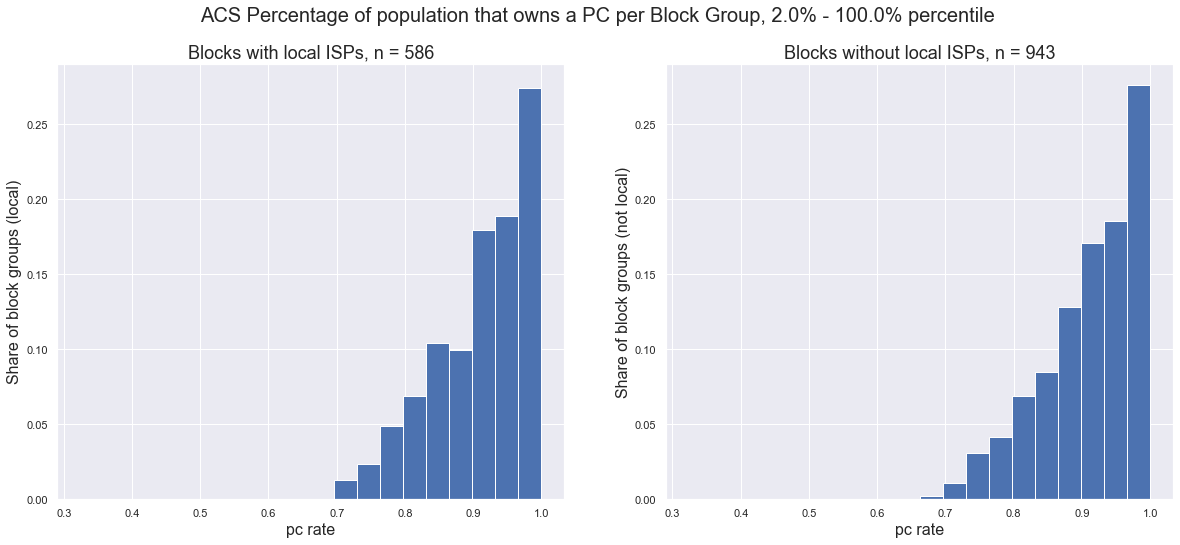

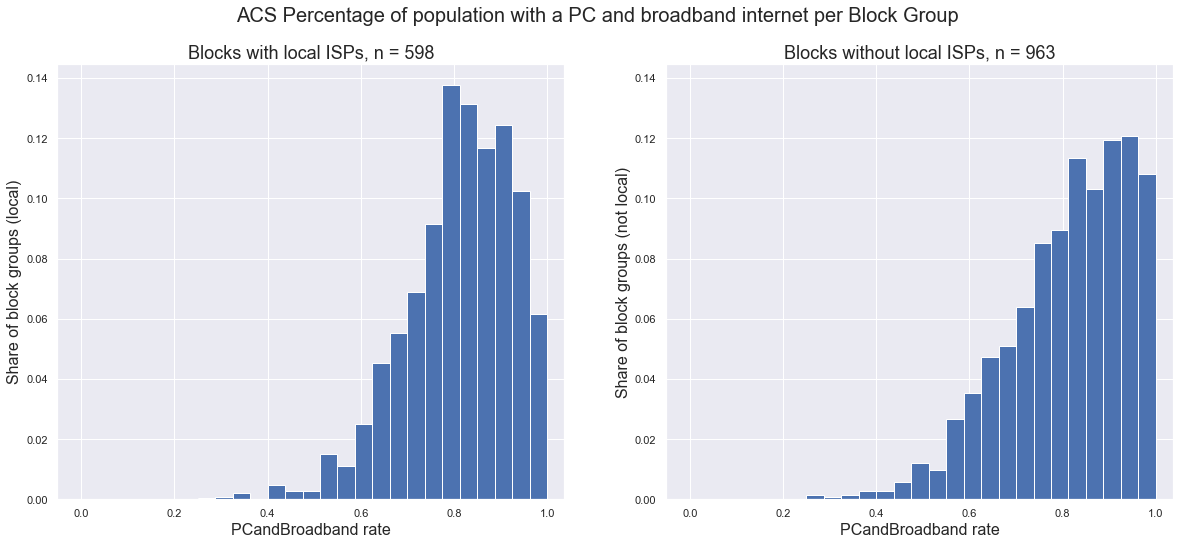

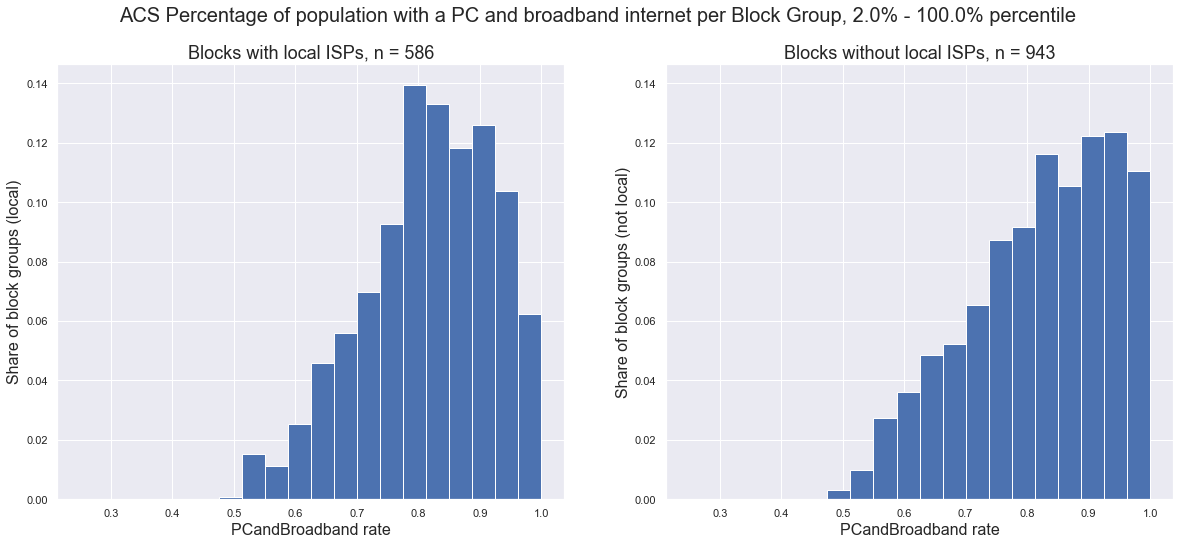

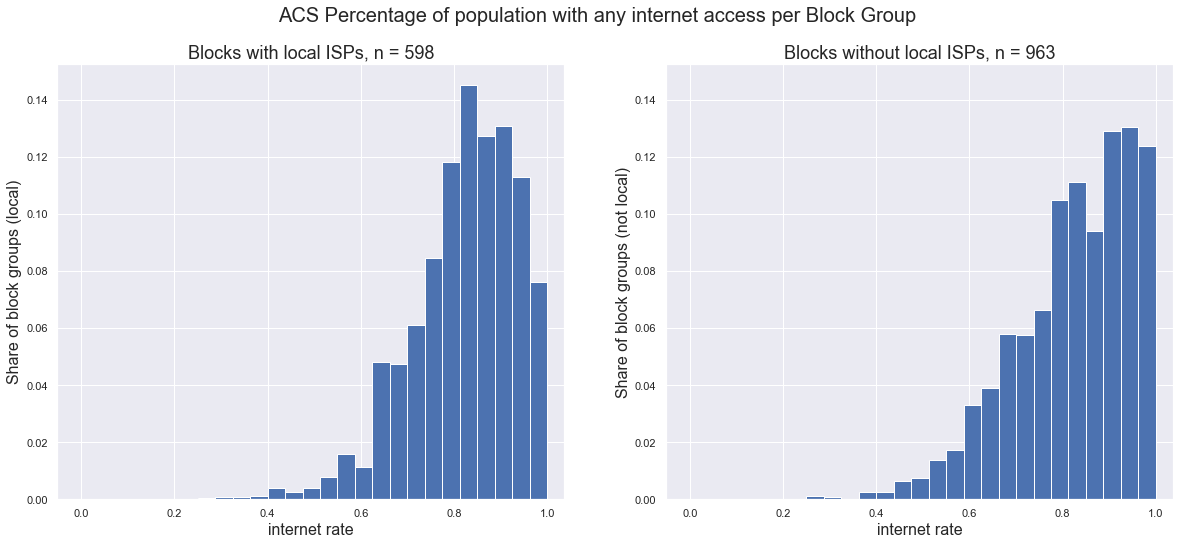

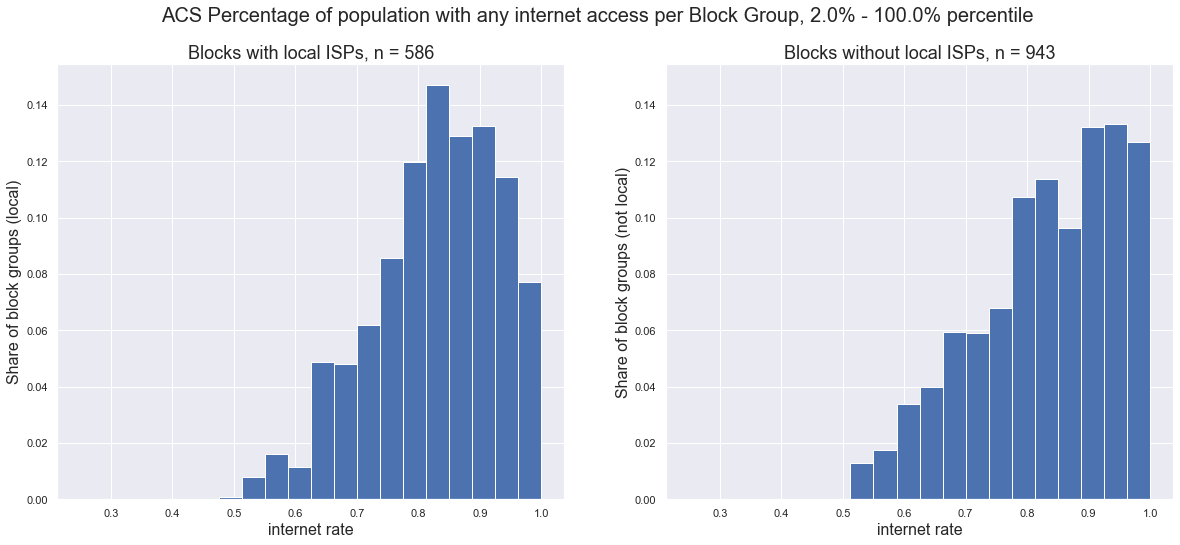

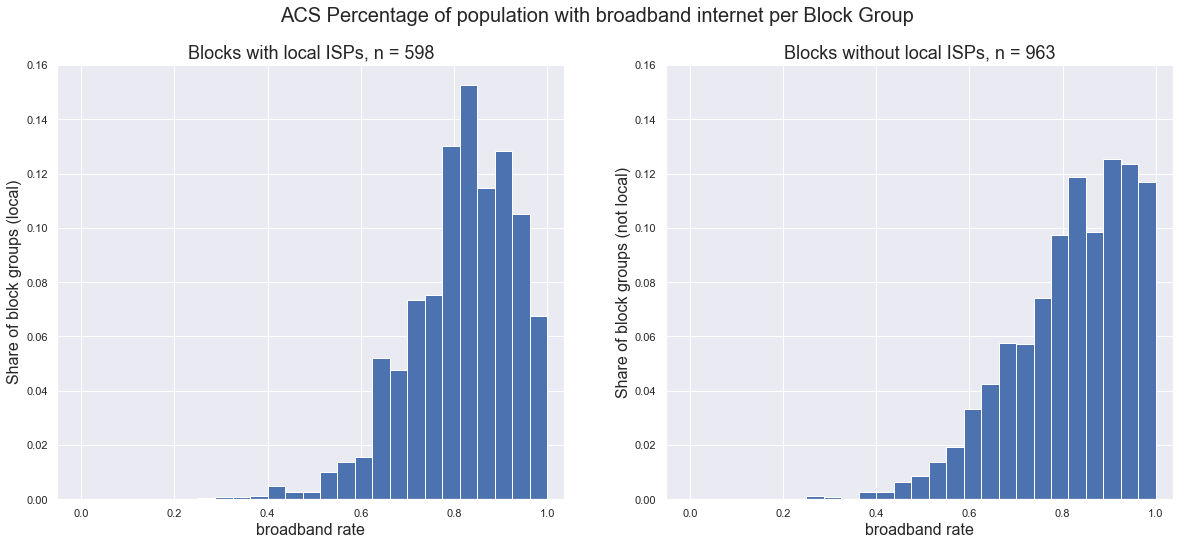

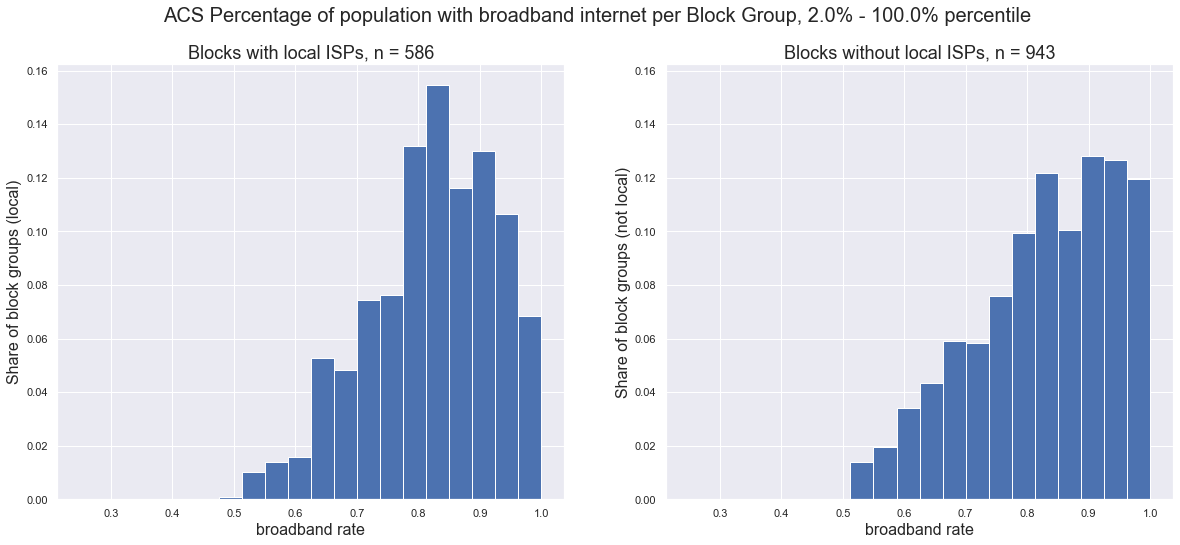

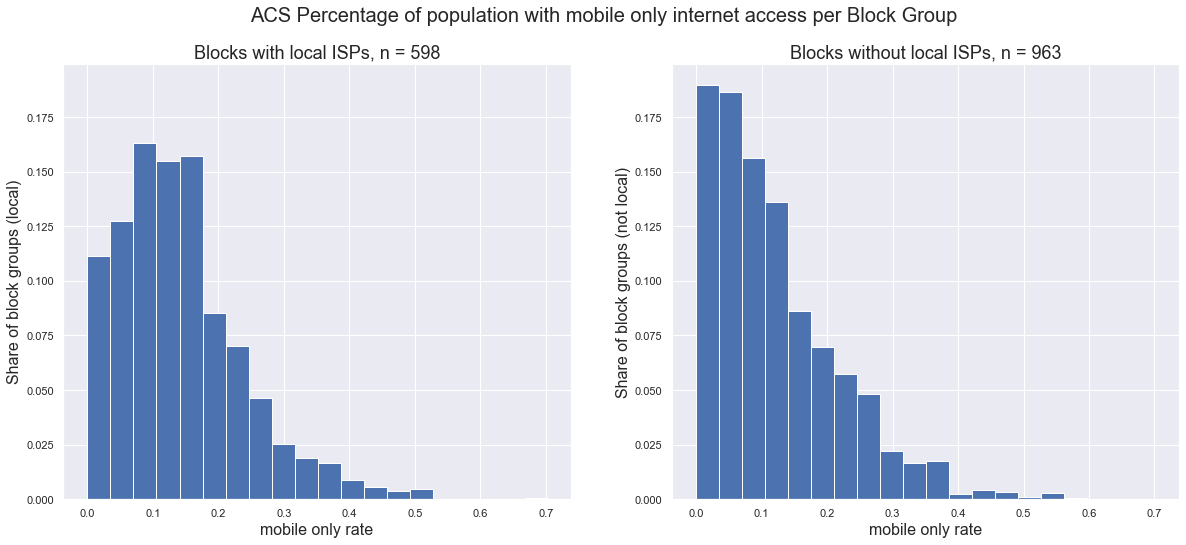

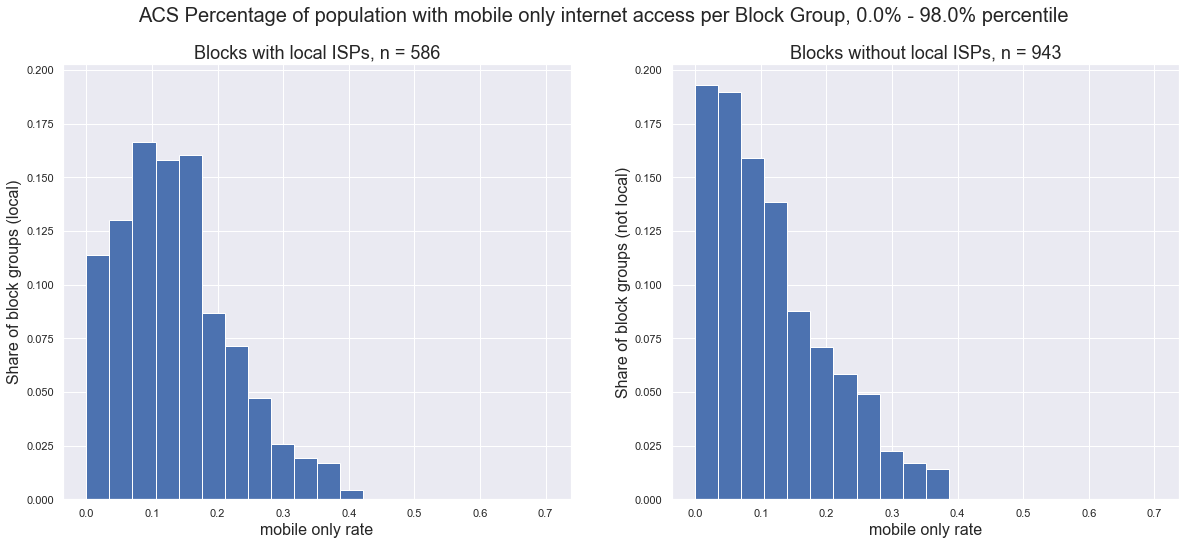

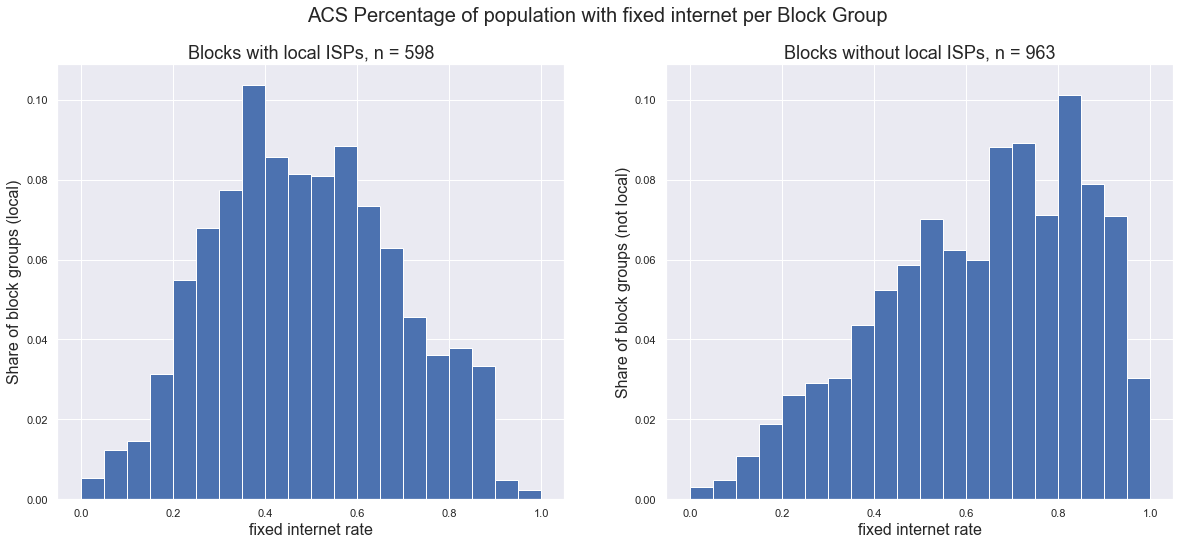

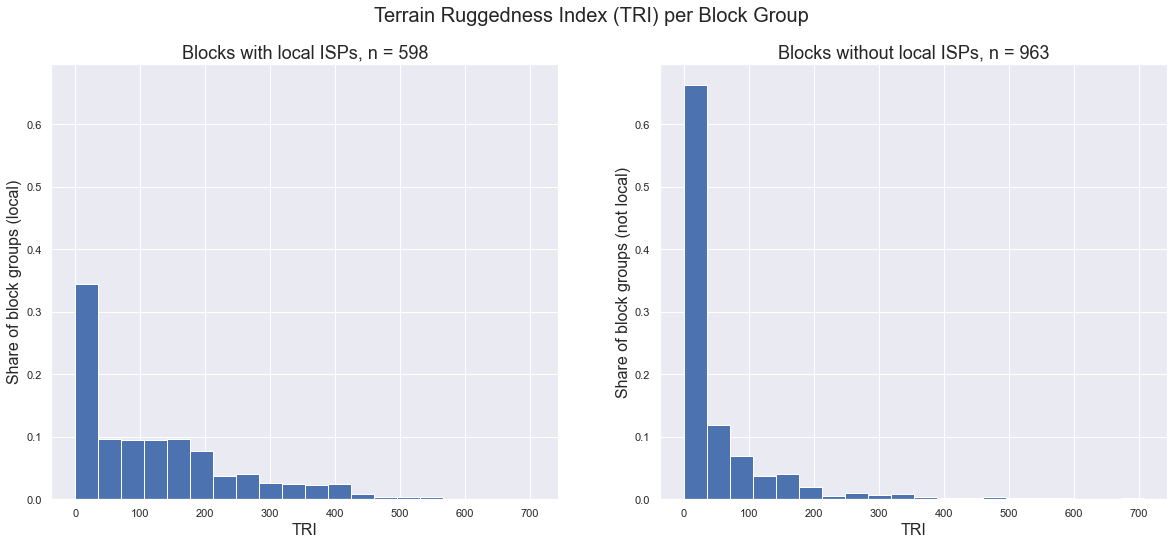

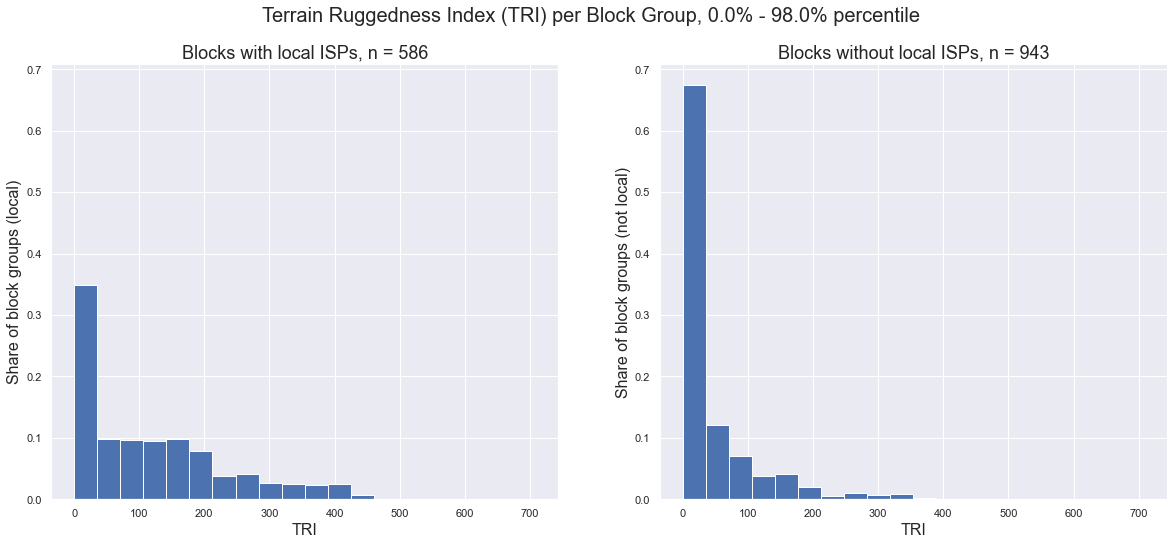

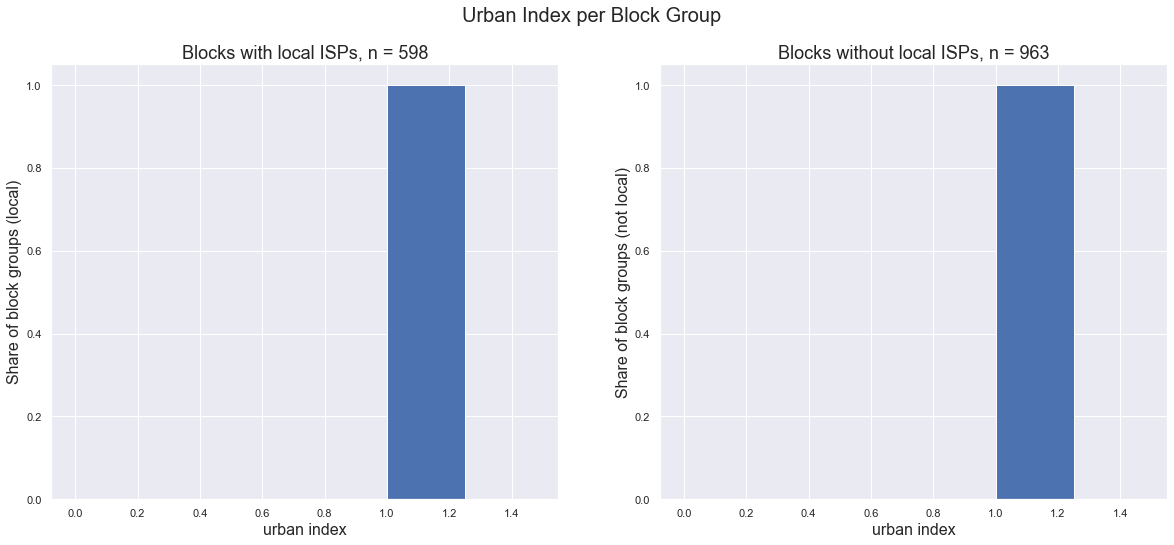

C:\Users\jongo\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jongo\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


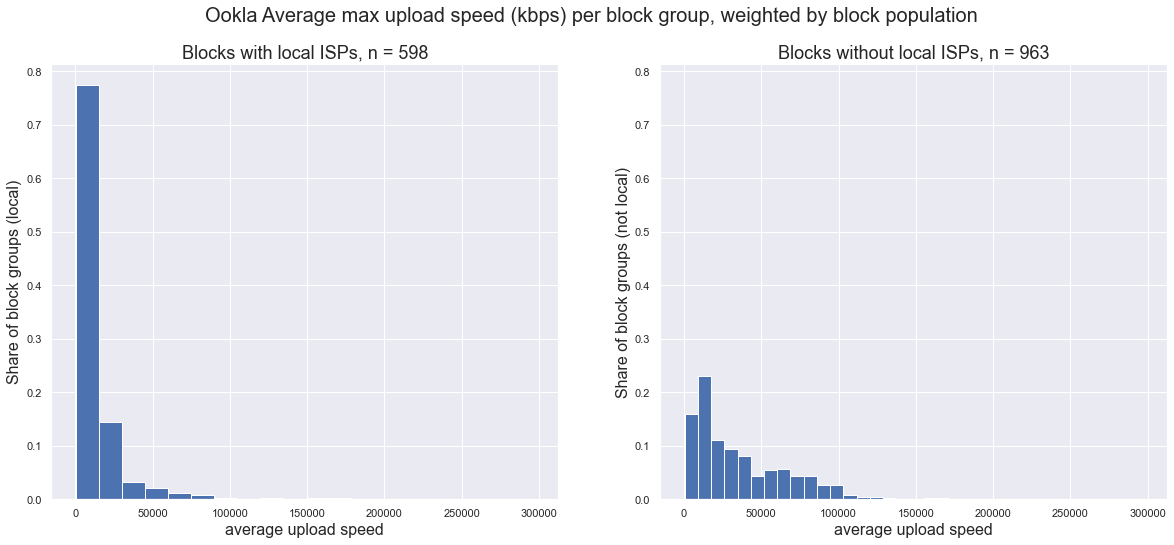

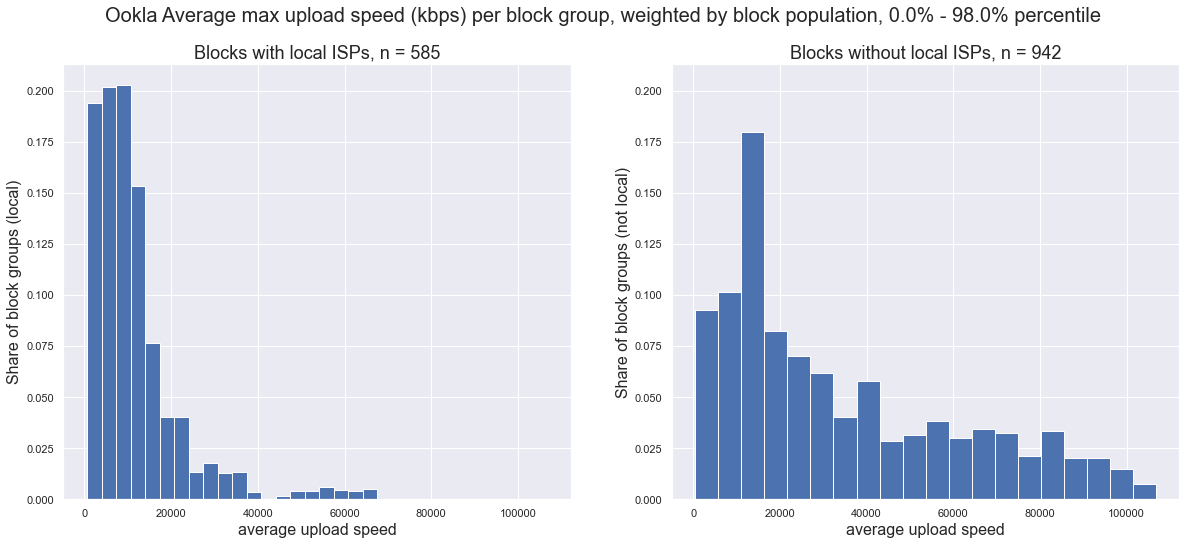

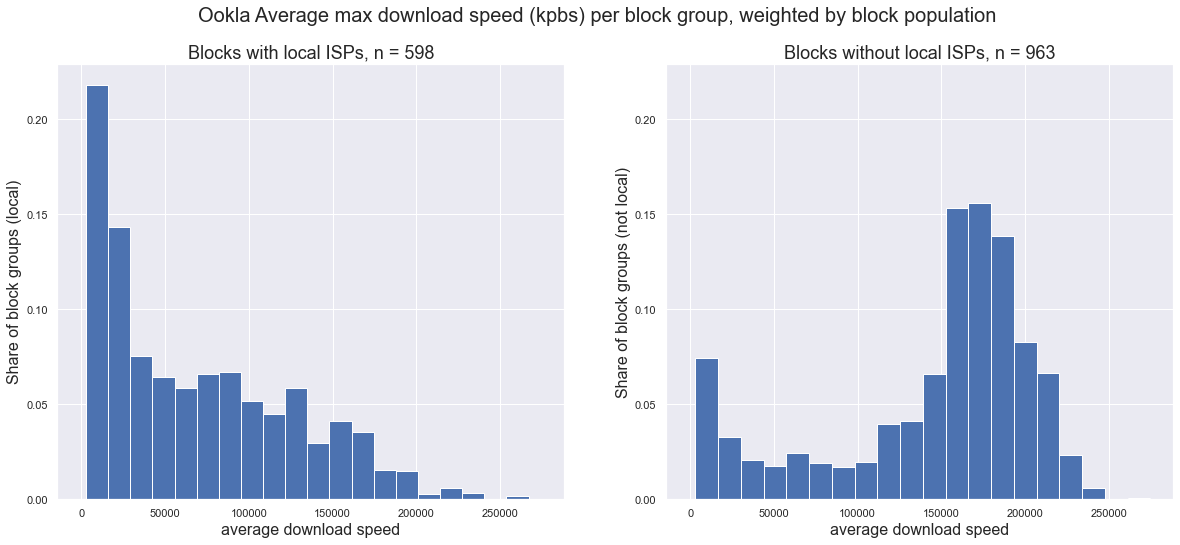

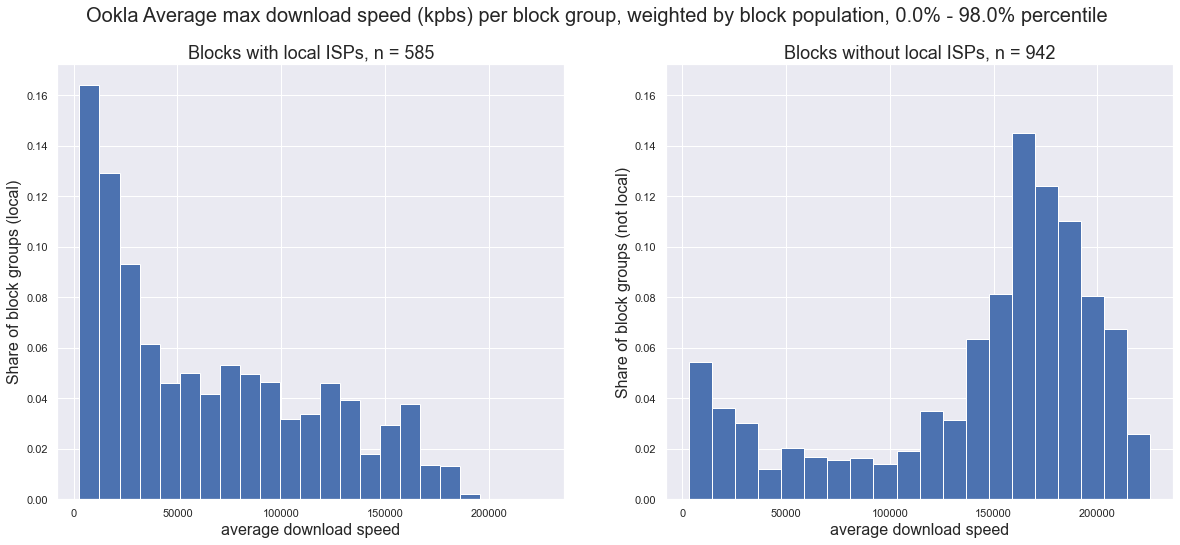

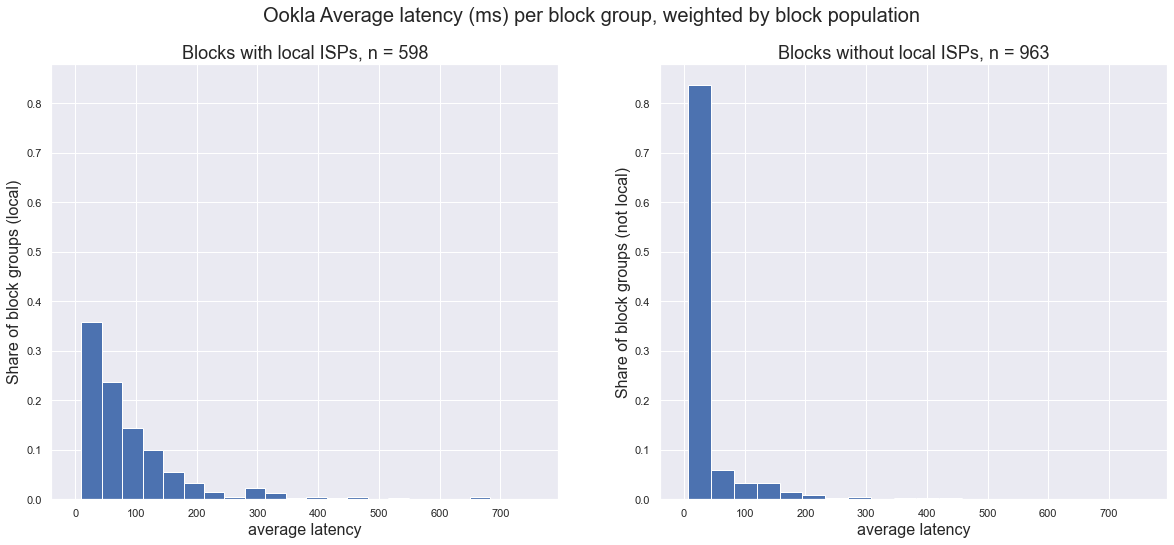

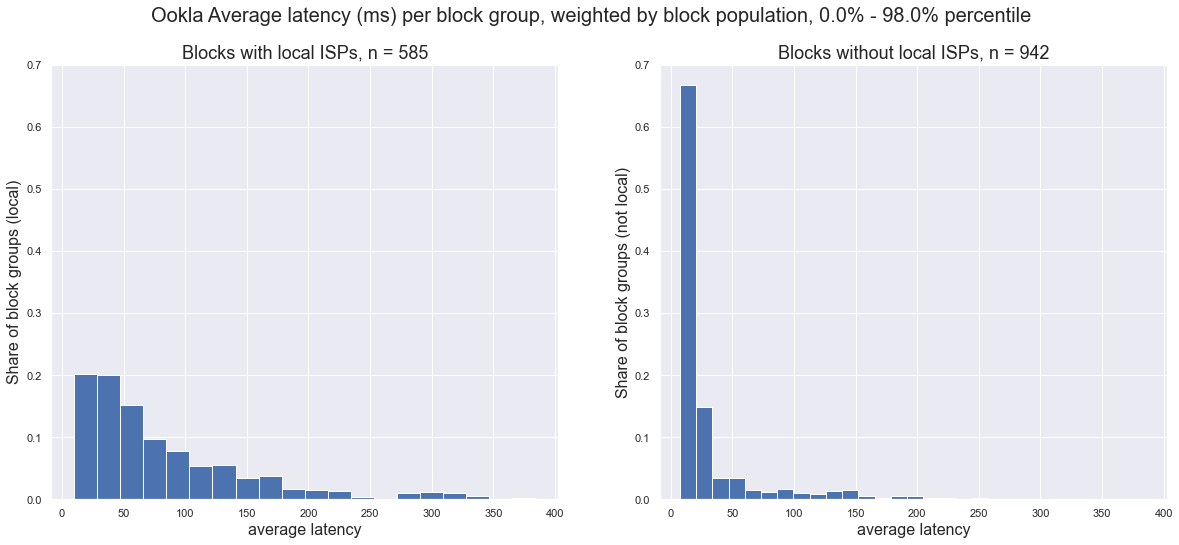

In [192]:
def show_double_plot(col, title, xlabel, bins, percentiles):
    
    fig, axes = plt.subplots(1,2, figsize=(20,8))
    
    treated_temp = treated[[col]+['A00001_001']]
    untreated_temp = untreated[[col]+['A00001_001']]
    
    n_treated   = len(treated_temp)
    n_untreated = len(untreated_temp)
    
    #weights=np.ones(len(treated_temp[col])) / len(treated_temp[col])
    
    treated_weights     = np.ones(len(treated_temp[col])) / len(treated_temp[col]) #* (treated_temp['A00001_001']/treated_temp['A00001_001'].sum())*100
    untreated_weights   = np.ones(len(untreated_temp[col])) / len(untreated_temp[col]) #* (untreated_temp['A00001_001']/untreated_temp['A00001_001'].sum())*100
    
    # ensure bin widths are equal between graphs
    if (col == 'avg_u_kbps_wt') or (col == 'avg_d_kbps_wt') or (col == 'avg_lat_ms_wt'):
        pass
    else:
        bins=np.histogram(np.hstack((treated_temp[col], untreated_temp[col])), bins=bins)[1]
    
    axes[0].hist(treated_temp[col],   bins = bins,   weights = (treated_temp['A00001_001']/treated_temp['A00001_001'].sum()),     figure=fig)
    axes[1].hist(untreated_temp[col], bins = bins, weights = (untreated_temp['A00001_001']/untreated_temp['A00001_001'].sum()), figure=fig)
    
    a = axes[0].get_ylim()
    b = axes[1].get_ylim()
    
    axes[0].set_ylim(bottom=0, top=max(a[1],b[1]))
    axes[1].set_ylim(bottom=0, top=max(a[1],b[1]))

    a = axes[0].get_xlim()
    b = axes[1].get_xlim()

    axes[0].set_xlim(-0.05*max(a[1],b[1]), max(a[1],b[1]))
    axes[1].set_xlim(-0.05*max(a[1],b[1]), max(a[1],b[1]))
    
    fig.suptitle(title, fontsize=20)

    axes[0].set_title('Blocks with local ISPs, n = '+ str(n_treated), fontsize=18)
    axes[1].set_title('Blocks without local ISPs, n = '+ str(n_untreated), fontsize=18)
    
    axes[0].set_ylabel('Share of block groups (local)', fontsize=16)
    axes[1].set_ylabel('Share of block groups (not local)', fontsize=16)
    
    axes[0].set_xlabel(xlabel, fontsize=16)
    axes[1].set_xlabel(xlabel, fontsize=16)
    
    plt.show()
    fig.savefig("C:/Users/jongo/Documents/College/Class/GRIDS/Microtelcos/figures/histograms/matching/with_outliers/" 
                + title +' with_outliers.png')
    plt.close()
    
    if percentiles is None:
        return
    
    treated_temp = treated[[col]+['A00001_001']]
    untreated_temp = untreated[[col]+['A00001_001']]
    
    # plot the histograms after removing outliers based on percentiles provided by user
    quant_df = treated_temp.quantile([percentiles[0], percentiles[1]])
    low  = quant_df.loc[percentiles[0], col]
    high = quant_df.loc[percentiles[1], col]
    treated_temp = treated_temp[(treated_temp[col]>=low) & (treated_temp[col]<=high)]
    
    quant_df = untreated_temp.quantile([percentiles[0], percentiles[1]])
    low  = quant_df.loc[percentiles[0], col]
    high = quant_df.loc[percentiles[1], col]
    untreated_temp = untreated_temp[(untreated_temp[col]>=low) & (untreated_temp[col]<=high)]
    
    title += ', ' + str(percentiles[0]*100)+'% - '+ str(percentiles[1]*100)+'% percentile'
    
    fig, axes = plt.subplots(1,2, figsize=(20,8))
    
    n_treated   = len(treated_temp)
    n_untreated = len(untreated_temp)

    treated_weights     = np.ones(len(treated_temp[col])) / len(treated_temp[col]) #* (treated_temp['A00001_001']/treated_temp['A00001_001'].sum())*100
    untreated_weights   = np.ones(len(untreated_temp[col])) / len(untreated_temp[col]) #* (untreated_temp['A00001_001']/untreated_temp['A00001_001'].sum())*100

    # ensure bin widths are equal between graphs
    if (col == 'avg_u_kbps_wt') or (col == 'avg_d_kbps_wt') or (col == 'avg_lat_ms_wt'):
        pass
    else:
        bins=np.histogram(np.hstack((treated_temp[col], untreated_temp[col])), bins=bins)[1]
    
    axes[0].hist(treated_temp[col],   bins = bins, weights = (treated_temp['A00001_001']/treated_temp['A00001_001'].sum()),   figure=fig)
    axes[1].hist(untreated_temp[col], bins = bins, weights = (untreated_temp['A00001_001']/untreated_temp['A00001_001'].sum()), figure=fig)

    a = axes[0].get_ylim()
    b = axes[1].get_ylim()

    axes[0].set_ylim(bottom=0, top=max(a[1],b[1]))
    axes[1].set_ylim(bottom=0, top=max(a[1],b[1]))

    a = axes[0].get_xlim()
    b = axes[1].get_xlim()

    axes[0].set_xlim(min(a[0],b[0]), max(a[1],b[1]))
    axes[1].set_xlim(min(a[0],b[0]), max(a[1],b[1]))
    
    fig.suptitle(title, fontsize=20)

    axes[0].set_title('Blocks with local ISPs, n = '+ str(n_treated), fontsize=18)
    axes[1].set_title('Blocks without local ISPs, n = '+ str(n_untreated), fontsize=18)
    
    axes[0].set_ylabel('Share of block groups (local)', fontsize=16)
    axes[1].set_ylabel('Share of block groups (not local)', fontsize=16)
    
    axes[0].set_xlabel(xlabel, fontsize=16)
    axes[1].set_xlabel(xlabel, fontsize=16)
    
    plt.show()
    
    fig.savefig("C:/Users/jongo/Documents/College/Class/GRIDS/Microtelcos/figures/histograms/matching/without_outliers/" 
                + title + ', ' + str(int(percentiles[0]*100))+'_' + str(int(percentiles[1]*100)) + '_percentile.png')

default_percentiles = [0.0,0.98]
reverse_percentiles = [0.02,1.0]
both_percentiles    = [0.02,0.98]

show_double_plot('served', 'CPUC Percentage of population with access to internet per Block Group', '% with access to internet',20, None)
show_double_plot('served25', 'CPUC Percentage of population with access to 25_3 internet per Block Group', '% with access to 25/3 internet',20, None)
show_double_plot('served100', 'CPUC Percentage of population with access to 100_10 internet per Block Group', '% with access to 100/10 internet',20, None)
show_double_plot('served_fib', 'CPUC Percentage of population with access to fiber internet per Block Group', '% with access to fiber internet',20, None)

show_double_plot('comp', 'CPUC Percentage of companies with access to internet per Block Group', '% with access to internet',20, None)
show_double_plot('comp25', 'CPUC Percentage of companies with access to 25_3 internet per Block Group', '% with access to 25/3 internet',20, None)
show_double_plot('comp100', 'CPUC Percentage of companies with access to 100_10 internet per Block Group', '% with access to 100/10 internet',20, None)
show_double_plot('comp_fib', 'CPUC Percentage of companies with access to fiber internet per Block Group', '% with access to fiber internet',20, None)

show_double_plot('max_up', 'CPUC Absolute max upload speed per block group', 'max upload speed',20, default_percentiles)
show_double_plot('max_dn', 'CPUC Absolute max download speed per block group', 'max download speed',20, default_percentiles)

show_double_plot('avg_max_up', 'CPUC Average max upload speed per block group, weighted by block population', 'average upload speed',20, default_percentiles)
show_double_plot('avg_max_dn', 'CPUC Average max download speed per block group, weighted by block population', 'average download speed',20, default_percentiles)

#show_double_plot('A00001_001', 'Total Population per Block Group', 'population',20, default_percentiles)
show_double_plot('A00002_002', 'Population Density (pop per sqmi) per Block Group', 'population density',20, default_percentiles)
show_double_plot('A00002_003', 'Land area (sqmi) per Block Group', 'land area',20, default_percentiles)
show_double_plot('A10003_001', 'Average Household size per Block Group', 'avg household size',20, None)
show_double_plot('A14006_001', 'Median Household income per Block Group', 'median income',20, default_percentiles)
show_double_plot('A14008_001', 'Average Household income per Block Group', 'average income',20, default_percentiles)
show_double_plot('A10036_001', 'Median House Value per Block Group', 'house value',20, default_percentiles)

show_double_plot('white', 'Percentage of White People per Block Group', '% white people',20, None)
show_double_plot('black', 'Percentage of Black People per Block Group', '% black people',10, default_percentiles)
show_double_plot('amindian', 'Percentage of Native American People per Block Group', '% aminidian people',10, default_percentiles)
show_double_plot('asian', 'Percentage of Asian People per Block Group', '% asian people', 10, default_percentiles)
show_double_plot('hispanic', 'Percentage of Hispanic People per Block Group', '% hispanic people',20, None)

show_double_plot('laborforce16', 'Laborforce participation rate (16+) per Block Group', 'laborforce patricipation rate',20, both_percentiles)
show_double_plot('unemployed', 'Unemployment rate per Block Group', 'unemployment rate',20, default_percentiles)
show_double_plot('povertyrate', 'Poverty Rate per Block Group', 'poverty rate',20, default_percentiles)
show_double_plot('lessHS', 'Percentage of population with less than high school education per Block Group', 'lessHS rate',20, default_percentiles)
show_double_plot('bachelor_more', 'Percentage of population with a Bachelor or higher per Block Group', 'bachelor rate',20, default_percentiles)

show_double_plot('nointernet', 'ACS Percentage of population with no access to internet per Block Group', 'nointernet rate',20, default_percentiles)
show_double_plot('has_pc', 'ACS Percentage of population that owns a PC per Block Group', 'pc rate',20, reverse_percentiles)
show_double_plot('has_pcandbroadband', 'ACS Percentage of population with a PC and broadband internet per Block Group', 'PCandBroadband rate',20, reverse_percentiles)
show_double_plot('has_internet', 'ACS Percentage of population with any internet access per Block Group', 'internet rate',20, reverse_percentiles)
show_double_plot('has_broadband', 'ACS Percentage of population with broadband internet per Block Group', 'broadband rate',20, reverse_percentiles)
show_double_plot('has_mobileonly', 'ACS Percentage of population with mobile only internet access per Block Group', 'mobile only rate',20, default_percentiles)
show_double_plot('has_cabledslfib', 'ACS Percentage of population with fixed internet per Block Group', 'fixed internet rate',20, None)

show_double_plot('tri', 'Terrain Ruggedness Index (TRI) per Block Group', 'TRI',20, default_percentiles)
show_double_plot('urban_index', 'Urban Index per Block Group', 'urban index', 4, None)

show_double_plot('avg_u_kbps_wt', 'Ookla Average max upload speed (kbps) per block group, weighted by block population', 'average upload speed',20, default_percentiles)
show_double_plot('avg_d_kbps_wt', 'Ookla Average max download speed (kpbs) per block group, weighted by block population', 'average download speed',20, default_percentiles)
show_double_plot('avg_lat_ms_wt', 'Ookla Average latency (ms) per block group, weighted by block population', 'average latency',20, default_percentiles)